# WWW: West Coast Wildfires and Weather
### Tutorial: Analysis of Wildfire and Weather Data

Mark Keller<br>
CMSC320<br>
Final Tutorial Project<br>
29 November 2018

#### Table of Contents
1. [Introduction](#1.-Introduction)
2. [Data](#2.-Data)<br>
    2.1 [West Coast Wildfire Data](#2.1-West-Coast-Wildfire-Data)<br>
    2.2 [Supplementary Weather Data](#2.2-Supplementary-Weather-Data)<br>
    2.3 [Merging the data](#2.3-Merging-the-data)
3. [Exploration](#3.-Exploration)<br>
    3.1 [Univariate Analysis](#3.1-Univariate-Analysis)<br>
    3.2 [Multivariate Analysis](#3.2-Multivariate-Analysis)
4. Hypothesis Testing
5. Regression Analysis
6. Classification Analysis
7. Conclusions


## 1. Introduction

For the past few weeks, the Camp Fire in Northern California has been a deadly and destructive force, recieving enormous media coverage. 
This deadly wildfire that began on November 8, 2018 has left [85 people dead, 249 missing, and destroyed thousands of buildings](https://www.usatoday.com/story/news/nation/2018/11/25/california-wildfire-camp-fire-contained/2107829002/).
It has resulted in major air quality issues, causing many to [wear masks](https://www.washingtonpost.com/nation/2018/11/17/behold-latest-sign-apocalypse-air-mask-selfies-fire-ravaged-california/?utm_term=.fe6d94c1991f) or [stay indoors](https://www.wired.com/story/smoke-from-wildfires-is-a-growing-public-health-crisis-for-cities/) to protect their health.
But this is not the first time a major wildfire has ravaged the west coast of the United States.

In this tutorial, we will analyze west coast wildfire data from 2010 to 2016, available through the University of California Irvine Data Science Initiative GitHub organization [here](https://github.com/UCIDataScienceInitiative/Climate_Hackathon/tree/master/west_coast_fires). This data has been obtained through the NASA [Moderate Resolution Imaging Spectroradiometer](https://en.wikipedia.org/wiki/Moderate_Resolution_Imaging_Spectroradiometer) (MODIS) satellite. We will merge this wildfire data with daily weather data obtained from NOAA Climate Data Online tool.

We will begin by loading the data and performing exploratory data analysis before diving deeper into regression analysis and classification analysis using basic machine learning methods. These data science methods will allow us to look at past trends and make inferences about future west coast wildfires.

<img src="https://www.fs.usda.gov/Internet/FSE_MEDIA/stelprdb5173318.jpg" alt="Wildfire Prevention" width="300"/>

## 2. Data

We will begin by importing Python packages that will help us to load and wrangle the data:
- `pandas`: a package that allows us to build data frames, a tabular data format that can be thought of like a spreadsheet
- `numpy`: a package containing matrix and vector mathematical functions

In [59]:
import pandas as pd
import numpy as np

### 2.1 West Coast Wildfire Data
The wildfire dataset is contained in a comma-separated values file (CSV) located on GitHub. Pandas has a `read_csv` function that allows us to load a data frame from a CSV over the web. We will specify the data types of each column using a python `dict` to ensure that pandas loads the data using the data types that we will want to use in our analysis.

In [60]:
data_url = 'https://raw.githubusercontent.com/UCIDataScienceInitiative/Climate_Hackathon/master/west_coast_fires/fires.csv'
dtype = {
    'confidence': float,
    'day': int,
    'frp': float,
    'lat': float,
    'lon': float,
    'month': int,
    'year': int,
    'x': float,
    'y': float,
    'dayofyear': int,
    'vdp': float,
    'temp': float,
    'humidity': float
}
df = pd.read_csv(data_url, dtype=dtype)
df.head()

id  confidence  day   frp     lat      lon  month  year            x  \
0  10122        0.61    1   6.0  32.997 -110.765      1  2010  1336.853783   
1  10123        0.72    1  11.1  32.995 -110.777      1  2010  1335.747633   
2  13460        0.57    2   6.3  33.650 -113.735      1  2010  1056.936097   
3  13461        0.62    2  10.2  32.358 -114.922      1  2010   950.464277   
4  22139        0.56    3  14.4  33.415 -110.860      1  2010  1325.030866   

         y  dayofyear       vpd    temp  humidity  
0  110.667          0  0.232254  271.10      55.8  
1  110.445          0  0.232254  271.10      55.8  
2  183.150          1  0.333371  272.70      43.6  
3   39.738          1  0.158511  274.70      76.8  
4  157.065          2  0.159304  268.62      63.5

We can use the `shape` variable to learn how many fire observations are contained in this dataset:

In [61]:
df.shape

(216232, 14)

The next step is to determine what this wildfire data means so that we can perform exploration. 
Luckily, the [README](https://github.com/UCIDataScienceInitiative/Climate_Hackathon/blob/master/west_coast_fires/README.md) for the GitHub repository provides us with a description of each column:

- `id`: unique identifier of the fire in the overall context of the world dataset
- `confidence`: how much confidence the satellite has that this is actually a fire detection (percent)
- `day`: the day of the month
- `frp`: Fire Radiative Power, the strength of the fire
- `lat`: latitude
- `lon`: longitude
- `month`: month of the year
- `year`: year
- `x`: x position in a uniformly-spaced grid
- `y`: y position in a uniformly-spaced grid
- `dayofyear`: day of the year (from 0 to 364 or 365 for leap years)
- `vpd`: [Vapor Pressure Deficit](https://en.wikipedia.org/wiki/Vapour-pressure_deficit), the difference between the moisture in the air and the amount of moisture the air could hold
- `temp`: temperature (degrees Kelvin)
- `humidity`: humidity (percent)


To be extra cautious, we can restrict our analysis to those fires with high confidence.

In [62]:
confidence_threshold = 0.8
df = df.loc[df['confidence'] > confidence_threshold]

We can observe the size of our data after filtering by `confidence` threshold.

In [63]:
df.shape

(97016, 14)

We will also want to exclude fires with a strength of zero.

In [64]:
frp_threshold = 1
df = df.loc[df['frp'] > frp_threshold]

We can again observe the size of our data, this time after filtering by `frp` threshold.

In [65]:
df.shape

(96821, 14)

The wildfire dataset README notes that the same fire may be split into separate observations if it spreads over multiple locations or last multiple days. We can try to remedy this by consolidating fire observations which:
- are close together
- span multiple consecutive days.

According to [the Wildfire page on Wikipedia](https://en.wikipedia.org/wiki/Wildfire#Physical_properties), forest fires can spread as fast as 10.8 km per hour. Using this information, we can consider that in a single day, it is possible that a fire could spread approximately 259 kilometers:

In [66]:
wildfire_max_daily_spread = 10.8*24
wildfire_max_daily_spread

259.20000000000005

To easily identify consecutive days, we will first add a column called `dayofdataset` which is similar to `dayofyear` but does not restart at the end of the year.

In [67]:
min_year = df['year'].min()
max_year = df['year'].max()
df['dayofdataset'] = df.apply(lambda row: (row['year'] - min_year) * 365 + row['dayofyear'], axis='columns')

Next we will take the difference of `dayofdataset` for each each row with the previous row. The resulting groups of rows that are 1 day or 0 days apart will be the candidates for our consolidation procedure.

In [68]:
df['dayofdataset_diff'] = df['dayofdataset'].diff()
df.head()

id  confidence  day   frp     lat      lon  month  year            x  \
6    40048        0.94    4  66.9  33.418 -110.862      1  2010  1324.823718   
22   64733        0.84    5  37.3  34.387 -111.540      1  2010  1255.567410   
40  103425        0.91    8  60.1  35.101 -112.093      1  2010  1200.490337   
41  103426        0.88    8  47.1  35.111 -112.095      1  2010  1200.247792   
42  103427        0.86    8  40.4  35.109 -112.109      1  2010  1198.984931   

          y  dayofyear       vpd    temp  humidity  dayofdataset  \
6   157.398          3  0.290486  270.57      42.5           3.0   
22  264.957          4  0.233602  266.02      34.7           4.0   
40  344.211          7  0.157593  261.97      39.4           7.0   
41  345.321          7  0.157593  261.97      39.4           7.0   
42  345.099          7  0.157593  261.97      39.4           7.0   

    dayofdataset_diff  
6                 NaN  
22                1.0  
40                3.0  
41                0.0  
42                0.0

Based on this date difference column, we can give each group of consecutive dates a different index, so that we can use `groupby` to iterate over each group of dates.

In [69]:
df = df.reset_index(drop=True)
df['date_group_index'] = np.nan
curr_date_group_index = 1
for index, row in df.iterrows():
    if pd.isna(row['dayofdataset_diff']) or row['dayofdataset_diff'] <= 1.0:
        df.at[index, 'date_group_index'] = curr_date_group_index
    else:
        curr_date_group_index += 1
df.head()

id  confidence  day   frp     lat      lon  month  year            x  \
0   40048        0.94    4  66.9  33.418 -110.862      1  2010  1324.823718   
1   64733        0.84    5  37.3  34.387 -111.540      1  2010  1255.567410   
2  103425        0.91    8  60.1  35.101 -112.093      1  2010  1200.490337   
3  103426        0.88    8  47.1  35.111 -112.095      1  2010  1200.247792   
4  103427        0.86    8  40.4  35.109 -112.109      1  2010  1198.984931   

         y  dayofyear       vpd    temp  humidity  dayofdataset  \
0  157.398          3  0.290486  270.57      42.5           3.0   
1  264.957          4  0.233602  266.02      34.7           4.0   
2  344.211          7  0.157593  261.97      39.4           7.0   
3  345.321          7  0.157593  261.97      39.4           7.0   
4  345.099          7  0.157593  261.97      39.4           7.0   

   dayofdataset_diff  date_group_index  
0                NaN               1.0  
1                1.0               1.0  
2                3.0               NaN  
3                0.0               2.0  
4                0.0               2.0

After grouping fires by date, the next step is to group the fires in a specific date group by location.

Our first thought might be to do pairwise comparison of distances between fires, using something like the [Haversine Formula](https://en.wikipedia.org/wiki/Haversine_formula) which computes distances between locations using their latitude and longitude values. 

In [70]:
# Adapted from this StackOverflow post: https://stackoverflow.com/a/4913653
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # radius of earth in kilometers
    return c * r

However, the size of our largest "date group" is over 20,000 rows:

In [71]:
max([date_group_df.shape[0] for date_group_index, date_group_df in df.groupby(['date_group_index'])])

23155

so the number of pairwise comparisons we would need to perform is _massive_:
$$ {23155 \choose 2} = 268065435 $$

We will need to be more clever. Perhaps a recently-open-sourced tool by Uber called [h3](https://uber.github.io/h3/#/) (and its python bindings at [h3-py](https://github.com/uber/h3-py)) can help us. 

In [72]:
from h3 import h3

`h3` is a "hierarchical hexagonal geospatial indexing system" and divides a geograpical space into hexagons, which have nice properties including approximating circles:

<img src="https://uber.github.io/h3/images/parent-child.png" alt="h3" width="300"/>

We can use the h3 [table of resolutions](https://uber.github.io/h3/#/documentation/core-library/resolution-table) to determine the size of hexagon that will best suit our needs. Considering the maximum wildfire spread per day is 259 km, and a circle with radius $\frac {259}{2}$ has the following area:

In [73]:
np.pi*(259/2)**2

52685.29419886423

We will choose resolution 3, because the area of resolution 2 is too large, so 3 is the closest match without going over.

Resolution 3 has the following properties:

| Average Hexagon Area (km2) | Average Hexagon Edge Length (km) | Number of unique indexes |
|----------------------------|----------------------------------|--------------------------|
| 12,392.2648621 | 59.810857940 | 41,162 |

In [74]:
h3_resolution = 3

Now we can assign each fire to a hexagon at this resolution:

In [75]:
def get_h3_address(row):
    return h3.geo_to_h3(row['lat'], row['lon'], h3_resolution)

df['h3_address'] = df.apply(get_h3_address, axis='columns')
df.head()

id  confidence  day   frp     lat      lon  month  year            x  \
0   40048        0.94    4  66.9  33.418 -110.862      1  2010  1324.823718   
1   64733        0.84    5  37.3  34.387 -111.540      1  2010  1255.567410   
2  103425        0.91    8  60.1  35.101 -112.093      1  2010  1200.490337   
3  103426        0.88    8  47.1  35.111 -112.095      1  2010  1200.247792   
4  103427        0.86    8  40.4  35.109 -112.109      1  2010  1198.984931   

         y  dayofyear       vpd    temp  humidity  dayofdataset  \
0  157.398          3  0.290486  270.57      42.5           3.0   
1  264.957          4  0.233602  266.02      34.7           4.0   
2  344.211          7  0.157593  261.97      39.4           7.0   
3  345.321          7  0.157593  261.97      39.4           7.0   
4  345.099          7  0.157593  261.97      39.4           7.0   

   dayofdataset_diff  date_group_index       h3_address  
0                NaN               1.0  8348ebfffffffff  
1                1.0               1.0  8348cdfffffffff  
2                3.0               NaN  8329b2fffffffff  
3                0.0               2.0  8329b2fffffffff  
4                0.0               2.0  8329b2fffffffff

We will use the h3 `k_ring` functionality to return the set of hexagons neighboring a given hexagon address:
<img src="https://uber.github.io/h3/images/neighbors.png" alt="h3" width="300"/>

In [76]:
h3.k_ring("8348ebfffffffff", 1) # demonstrating the k_ring function

{'8329b6fffffffff',
 '8348ccfffffffff',
 '8348cdfffffffff',
 '8348e8fffffffff',
 '8348e9fffffffff',
 '8348eafffffffff',
 '8348ebfffffffff'}

We will do this for all fires in each "date group" and assign a new "fire group" index to those fires within one hexagon of each other:

In [77]:
curr_max_fire_group_index = df.shape[0]
df['fire_group_index'] = np.arange(curr_max_fire_group_index)

for date_group_index, date_group_df in df.groupby(['date_group_index']):
    date_group_h3_address_set = set(date_group_df['h3_address'].unique())
    while len(date_group_h3_address_set) > 0:
        h3_address = date_group_h3_address_set.pop()
        h3_address_k_ring_set = h3.k_ring(h3_address, 1)
        h3_address_k_ring_set_df = date_group_df.loc[date_group_df['h3_address'].isin(h3_address_k_ring_set)]
        curr_max_fire_group_index += 1
        for fire_index_in_group in list(h3_address_k_ring_set_df.index.values):
            df.at[fire_index_in_group, 'fire_group_index'] = curr_max_fire_group_index
        date_group_h3_address_set = (date_group_h3_address_set - h3_address_k_ring_set)

df.head()

id  confidence  day   frp     lat      lon  month  year            x  \
0   40048        0.94    4  66.9  33.418 -110.862      1  2010  1324.823718   
1   64733        0.84    5  37.3  34.387 -111.540      1  2010  1255.567410   
2  103425        0.91    8  60.1  35.101 -112.093      1  2010  1200.490337   
3  103426        0.88    8  47.1  35.111 -112.095      1  2010  1200.247792   
4  103427        0.86    8  40.4  35.109 -112.109      1  2010  1198.984931   

         y  dayofyear       vpd    temp  humidity  dayofdataset  \
0  157.398          3  0.290486  270.57      42.5           3.0   
1  264.957          4  0.233602  266.02      34.7           4.0   
2  344.211          7  0.157593  261.97      39.4           7.0   
3  345.321          7  0.157593  261.97      39.4           7.0   
4  345.099          7  0.157593  261.97      39.4           7.0   

   dayofdataset_diff  date_group_index       h3_address  fire_group_index  
0                NaN               1.0  8348ebfffffffff             96822  
1                1.0               1.0  8348cdfffffffff             96822  
2                3.0               NaN  8329b2fffffffff                 2  
3                0.0               2.0  8329b2fffffffff             96823  
4                0.0               2.0  8329b2fffffffff             96823

Later we will be able to use the `fire_group_index` column to identify our groups of fire observations as single fires.

### 2.2 Supplementary Weather Data
Using the NOAA [Climate Data Online (CDO)](https://www.ncdc.noaa.gov/cdo-web/search) service, we can obtain daily climate data from 2010 to 2016, from weather stations in the west coast. The CDO search tool allows us to select NOAA stations of interest and the types of data we want to download for a specified time period.  In this case, I have manually selected 75 [weather stations](https://www.ncdc.noaa.gov/cdo-web/datatools/findstation) spread throughout the west coast region. 

Along with the location (latitude and longitude) of each weather station, I selected to download data comprising the following variables:

__Air Temperature__<br>
- `TAVG`: Average Temperature
- `TMAX`: Maximum temperature
- `TMIN`: Minimum temperature

__Precipitation__<br>
- `MDPR`: Multiday precipitation total (use with DAPR and DWPR, if available)
- `DAPR`: Number of days included in the multiday precipitation total (MDPR)
- `PRCP`: Precipitation
- `SNWD`: Snow depth
- `SNOW`: Snowfall

__Sunshine__<br>
- `PSUN`: Daily percent of possible sunshine for the period
- `TSUN`: Total sunshine for the period

__Wind__<br>
- `AWND`: Average wind speed
- `WDF2`: Direction of fastest 2-minute wind
- `WDF5`: Direction of fastest 5-second wind 
- `WSF2`: Fastest 2-minute wind speed
- `WSF5`: Fastest 5-second wind speed
- `PGTM`: Peak gust time
- `FMTM`: Time of fastest mile or fastest 1-minute wind

__Weather Type__: binary indication of specific weather events<br>
- `WT01`: Fog, ice fog, or freezing fog (may include heavy fog)
- `WT02`: Heavy fog or heaving freezing fog (not always distinguished from fog)
- `WT03`: Thunder
- `WT04`: Ice pellets, sleet, snow pellets, or small hail
- `WT05`: Hail (may include small hail)
- `WT06`: Glaze or rime 
- `WT07`: Dust, volcanic ash, blowing dust, blowing sand, or blowing obstruction
- `WT08`: Smoke or haze
- `WT09`: Blowing or drifting snow
- `WT10`: Tornado, waterspout, or funnel cloud
- `WT11`: High or damaging winds
- `WT13`: Mist
- `WT14`: Drizzle
- `WT15`: Freezing drizzle
- `WT16`: Rain (may include freezing rain, drizzle, and freezing drizzle)
- `WT17`: Freezing rain
- `WT18`: Snow, snow pellets, snow grains, or ice crystals
- `WT19`: Unknown source of precipitation
- `WT21`: Ground fog 
- `WT22`: Ice fog or freezing fog

After selecting data, the CDO tool sends an email with our requested data to download. I have done this and place the downloaded file in this GitHub repository so that we can easily load it with `pandas`.

In [78]:
cdo_df = pd.read_csv('data/1572799.csv')
cdo_df.head()

STATION                             NAME  LATITUDE  LONGITUDE  \
0  USW00024133  BURLEY MUNICIPAL AIRPORT, ID US   42.5416  -113.7661   
1  USW00024133  BURLEY MUNICIPAL AIRPORT, ID US   42.5416  -113.7661   
2  USW00024133  BURLEY MUNICIPAL AIRPORT, ID US   42.5416  -113.7661   
3  USW00024133  BURLEY MUNICIPAL AIRPORT, ID US   42.5416  -113.7661   
4  USW00024133  BURLEY MUNICIPAL AIRPORT, ID US   42.5416  -113.7661   

   ELEVATION        DATE   AWND  DAPR    FMTM  MDPR  ...   WT11  WT13  WT14  \
0     1266.1  2010-01-01  13.65   NaN  1009.0   NaN  ...    NaN   1.0   NaN   
1     1266.1  2010-01-02   9.84   NaN   206.0   NaN  ...    NaN   1.0   NaN   
2     1266.1  2010-01-03   5.59   NaN  2359.0   NaN  ...    NaN   NaN   NaN   
3     1266.1  2010-01-04    NaN   NaN   228.0   NaN  ...    NaN   NaN   NaN   
4     1266.1  2010-01-05    NaN   NaN  2340.0   NaN  ...    NaN   NaN   NaN   

   WT15  WT16  WT17  WT18  WT19  WT21  WT22  
0   NaN   1.0   NaN   1.0   1.0   NaN   NaN  
1   NaN   1.0   NaN   1.0   NaN   NaN   NaN  
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 44 columns]

And taking note of the size of this data frame:

In [79]:
cdo_df.shape

(188890, 44)

### 2.3 Merging the data

To be able to match this weather data with our wildfire data, we will look at the weather from the closest station to each fire observation. 

We will first need to map each station to its location.

In [80]:
cdo_loc_df = cdo_df.drop_duplicates(subset=['STATION'])[['STATION', 'LATITUDE', 'LONGITUDE']].set_index('STATION', drop=True)
cdo_loc_df.head()

LATITUDE  LONGITUDE
STATION                         
USW00024133   42.5416 -113.76610
USW00024131   43.5666 -116.24050
USW00093075   38.7500 -109.76278
USW00024132   45.7880 -111.16080
USW00093230   38.8983 -119.99470

Using the `haversine` formula from above, we can write a function that returns the ID of the closest weather station and the distance (in kilometers), given the coordinates of a fire:

In [81]:
def get_closest_station(fire_lon, fire_lat):
    station_distance_series = cdo_loc_df.apply(lambda row: haversine(row['LONGITUDE'], row['LATITUDE'], fire_lon, fire_lat), axis='columns')
    return (station_distance_series.idxmin(), station_distance_series.min())

Now we can apply this function along the entire wildfire dataframe, creating two new columns:

In [82]:
df['closest_station'], df['closest_station_dist'] = zip(*df.apply(lambda row: get_closest_station(row['lon'], row['lat']), axis='columns'))
df.head()

id  confidence  day   frp     lat      lon  month  year            x  \
0   40048        0.94    4  66.9  33.418 -110.862      1  2010  1324.823718   
1   64733        0.84    5  37.3  34.387 -111.540      1  2010  1255.567410   
2  103425        0.91    8  60.1  35.101 -112.093      1  2010  1200.490337   
3  103426        0.88    8  47.1  35.111 -112.095      1  2010  1200.247792   
4  103427        0.86    8  40.4  35.109 -112.109      1  2010  1198.984931   

         y         ...                vpd    temp  humidity  dayofdataset  \
0  157.398         ...           0.290486  270.57      42.5           3.0   
1  264.957         ...           0.233602  266.02      34.7           4.0   
2  344.211         ...           0.157593  261.97      39.4           7.0   
3  345.321         ...           0.157593  261.97      39.4           7.0   
4  345.099         ...           0.157593  261.97      39.4           7.0   

   dayofdataset_diff  date_group_index       h3_address fire_group_index  \
0                NaN               1.0  8348ebfffffffff            96822   
1                1.0               1.0  8348cdfffffffff            96822   
2                3.0               NaN  8329b2fffffffff                2   
3                0.0               2.0  8329b2fffffffff            96823   
4                0.0               2.0  8329b2fffffffff            96823   

   closest_station closest_station_dist  
0      USW00023183           105.971337  
1      USW00003103            84.972498  
2      USW00003103            39.102676  
3      USW00003103            39.160723  
4      USW00003103            40.449813  

[5 rows x 21 columns]

The mean distance from fires to the closest weather station is approximately 79 kilometers, or 49 miles:

In [83]:
df['closest_station_dist'].mean()

78.8566412646424

Turning our attention to the weather dataframe now, we will convert its date values into a `dayofyear` column so that we can easily cross-reference from the wildfire dataset to determine the weather on the day of a fire.

We will need to import python's `datetime` to help with date formatting.

In [84]:
import datetime

In [85]:
def cdo_date_to_dayofyear(cdo_date):
    date = datetime.datetime.fromisoformat(cdo_date).date()
    return int(date.strftime('%-j'))

def cdo_date_to_year(cdo_date):
    date = datetime.datetime.fromisoformat(cdo_date).date()
    return int(date.strftime('%Y'))

Now we can apply this conversion function to all of the date values in the CDO weather dataset:

In [86]:
cdo_df['dayofyear'] = cdo_df['DATE'].apply(cdo_date_to_dayofyear)
cdo_df['year'] = cdo_df['DATE'].apply(cdo_date_to_year)
cdo_df['dayofdataset'] = cdo_df.apply(lambda row: (row['year'] - min_year) * 365 + row['dayofyear'], axis='columns')

Next, we can compute periods of drought.

We can perform a similar process as we did before when computing groups of dates for the wildfires, and assign unique indices to groups of consecutive observations (from the same weather station) with zero values for the `PRCP` precipitation column.

In [87]:
cdo_df['drought_group_index'] = np.nan
curr_drought_index = 1

for station_name, station_df in cdo_df.groupby(['STATION']):
    for index, row in station_df.iterrows():
        if pd.isna(row['PRCP']) or row['PRCP'] == 0.0:
            cdo_df.at[index, 'drought_group_index'] = curr_drought_index
        else:
            curr_drought_index += 1
cdo_df.head()

STATION                             NAME  LATITUDE  LONGITUDE  \
0  USW00024133  BURLEY MUNICIPAL AIRPORT, ID US   42.5416  -113.7661   
1  USW00024133  BURLEY MUNICIPAL AIRPORT, ID US   42.5416  -113.7661   
2  USW00024133  BURLEY MUNICIPAL AIRPORT, ID US   42.5416  -113.7661   
3  USW00024133  BURLEY MUNICIPAL AIRPORT, ID US   42.5416  -113.7661   
4  USW00024133  BURLEY MUNICIPAL AIRPORT, ID US   42.5416  -113.7661   

   ELEVATION        DATE   AWND  DAPR    FMTM  MDPR         ...           \
0     1266.1  2010-01-01  13.65   NaN  1009.0   NaN         ...            
1     1266.1  2010-01-02   9.84   NaN   206.0   NaN         ...            
2     1266.1  2010-01-03   5.59   NaN  2359.0   NaN         ...            
3     1266.1  2010-01-04    NaN   NaN   228.0   NaN         ...            
4     1266.1  2010-01-05    NaN   NaN  2340.0   NaN         ...            

   WT16  WT17  WT18  WT19  WT21  WT22  dayofyear  year  dayofdataset  \
0   1.0   NaN   1.0   1.0   NaN   NaN          1  2010             1   
1   1.0   NaN   1.0   NaN   NaN   NaN          2  2010             2   
2   NaN   NaN   NaN   NaN   NaN   NaN          3  2010             3   
3   NaN   NaN   NaN   NaN   NaN   NaN          4  2010             4   
4   NaN   NaN   NaN   NaN   NaN   NaN          5  2010             5   

   drought_group_index  
0                  NaN  
1                  NaN  
2              14041.0  
3              14041.0  
4              14041.0  

[5 rows x 48 columns]

We can create a new dataframe containing the start day, end day, and length of each drought period:

In [88]:
drought_df = pd.DataFrame(data=[], index=[], columns=['STATION', 'drought_group_index', 'dayofdataset_start', 'dayofdataset_end', 'length'])
for drought_group_index, drought_group_df in cdo_df.groupby(['drought_group_index']):
    if pd.notnull(drought_group_index):
        drought_group_df_index_vals = list(drought_group_df.index.values)
        drought_group_start_day = drought_group_df.loc[drought_group_df_index_vals[0]]['dayofdataset']
        drought_group_end_day = drought_group_df.loc[drought_group_df_index_vals[-1]]['dayofdataset']
        drought_group_length = (drought_group_end_day - drought_group_start_day)
        drought_group_station = drought_group_df.loc[drought_group_df_index_vals[0]]['STATION']
        if drought_group_length > 0:
            drought_df = drought_df.append({
                'STATION': drought_group_station,
                'drought_group_index': drought_group_index,
                'dayofdataset_start': drought_group_start_day,
                'dayofdataset_end': drought_group_end_day,
                'length': drought_group_length
            }, ignore_index=True)

drought_df.head()

STATION  drought_group_index dayofdataset_start dayofdataset_end length
0  USC00425654                  1.0                  1               13     12
1  USC00425654                  2.0                 15               19      4
2  USC00425654                  4.0                 23               26      3
3  USC00425654                  6.0                 29               36      7
4  USC00425654                  8.0                 39               50     11

Finally we are ready to merge our drought data with our fire data. We will add a new column to indicate how long of a drought (if any) preceded the fire. 

In [89]:
def get_drought_length(row):
    fire_drought_df = drought_df.loc[
        (drought_df['STATION'] == row['closest_station']) & 
        (drought_df['dayofdataset_start'] <= row['dayofdataset']) &
        (drought_df['dayofdataset_end'] >= row['dayofdataset'])
    ]
    if fire_drought_df.shape[0] == 1:
        return (row['dayofdataset'] - fire_drought_df.reset_index(drop=True).loc[0]['dayofdataset_start'])
    else:
        return 0

df['drought_length'] = df.apply(get_drought_length, axis='columns')
df.head()

id  confidence  day   frp     lat      lon  month  year            x  \
0   40048        0.94    4  66.9  33.418 -110.862      1  2010  1324.823718   
1   64733        0.84    5  37.3  34.387 -111.540      1  2010  1255.567410   
2  103425        0.91    8  60.1  35.101 -112.093      1  2010  1200.490337   
3  103426        0.88    8  47.1  35.111 -112.095      1  2010  1200.247792   
4  103427        0.86    8  40.4  35.109 -112.109      1  2010  1198.984931   

         y      ...          temp  humidity  dayofdataset  dayofdataset_diff  \
0  157.398      ...        270.57      42.5           3.0                NaN   
1  264.957      ...        266.02      34.7           4.0                1.0   
2  344.211      ...        261.97      39.4           7.0                3.0   
3  345.321      ...        261.97      39.4           7.0                0.0   
4  345.099      ...        261.97      39.4           7.0                0.0   

   date_group_index       h3_address  fire_group_index closest_station  \
0               1.0  8348ebfffffffff             96822     USW00023183   
1               1.0  8348cdfffffffff             96822     USW00003103   
2               NaN  8329b2fffffffff                 2     USW00003103   
3               2.0  8329b2fffffffff             96823     USW00003103   
4               2.0  8329b2fffffffff             96823     USW00003103   

   closest_station_dist drought_length  
0            105.971337            2.0  
1             84.972498            3.0  
2             39.102676            6.0  
3             39.160723            6.0  
4             40.449813            6.0  

[5 rows x 22 columns]

Next we can merge wind data with each fire observation. Perhaps fires are stronger or last longer during periods with high wind speed.

Using the "fire groups" we can create a new dataset containing one observation for each group:

In [90]:
grouped_df_columns = [
    'fire_group_index',
    'fire_group_size',
    'day_start',
    'day_end',
    'frp_mean',
    'frp_sum',
    'lat_min',
    'lat_max',
    'lon_min',
    'lon_max',
    'month_start',
    'month_end',
    'year_start',
    'year_end',
    'dayofyear_start',
    'dayofyear_end',
    'dayofdataset_start',
    'dayofdataset_end',
    'x_min',
    'x_max',
    'y_min',
    'y_max',
    'vpd_mean',
    'temp_mean',
    'humidity_mean',
    'drought_length'
]
grouped_df = pd.DataFrame(data=[], index=[], columns=grouped_df_columns)

for fire_group_index, fire_group_df in df.groupby(['fire_group_index']):
    fire_group_df = fire_group_df.reset_index(drop=True)
    start_row = fire_group_df.loc[0]
    end_row = fire_group_df.loc[fire_group_df.shape[0]-1]
    grouped_df = grouped_df.append({
        'fire_group_index': fire_group_index,
        'fire_group_size': fire_group_df.shape[0],
        'day_start': start_row['day'],
        'day_end': end_row['day'],
        'frp_mean': fire_group_df['frp'].mean(),
        'frp_sum': fire_group_df['frp'].sum(),
        'lat_min': fire_group_df['lat'].min(),
        'lat_max': fire_group_df['lat'].max(),
        'lon_min': fire_group_df['lon'].min(),
        'lon_max': fire_group_df['lon'].max(),
        'month_start': start_row['month'],
        'month_end': end_row['month'],
        'year_start': start_row['year'],
        'year_end': end_row['year'],
        'dayofyear_start': start_row['dayofyear'],
        'dayofyear_end': end_row['dayofyear'],
        'dayofdataset_start': start_row['dayofdataset'],
        'dayofdataset_end': end_row['dayofdataset'],
        'x_min': fire_group_df['x'].min(),
        'x_max': fire_group_df['x'].max(),
        'y_min': fire_group_df['y'].min(),
        'y_max': fire_group_df['y'].max(),
        'vpd_mean': fire_group_df['vpd'].mean(),
        'temp_mean': fire_group_df['temp'].mean(),
        'humidity_mean': fire_group_df['humidity'].mean(),
        'drought_length': start_row['drought_length'],
    }, ignore_index=True)
    
grouped_df.head()

fire_group_index  fire_group_size  day_start  day_end  frp_mean  frp_sum  \
0               2.0              1.0        8.0      8.0      60.1     60.1   
1               5.0              1.0       11.0     11.0      69.7     69.7   
2              16.0              1.0       30.0     30.0      26.9     26.9   
3              18.0              1.0        2.0      2.0      77.6     77.6   
4              26.0              1.0       11.0     11.0      21.0     21.0   

   lat_min  lat_max  lon_min  lon_max       ...        dayofdataset_start  \
0   35.101   35.101 -112.093 -112.093       ...                       7.0   
1   39.143   39.143 -120.661 -120.661       ...                      10.0   
2   33.456   33.456 -114.702 -114.702       ...                      29.0   
3   32.660   32.660 -115.602 -115.602       ...                      32.0   
4   34.082   34.082 -114.296 -114.296       ...                      41.0   

   dayofdataset_end        x_min        x_max    y_min    y_max  vpd_mean  \
0               7.0  1200.490337  1200.490337  344.211  344.211  0.157593   
1              10.0   435.128728   435.128728  792.873  792.873  0.222111   
2              29.0   967.909213   967.909213  161.616  161.616  0.217424   
3              32.0   885.921867   885.921867   73.260   73.260  0.254992   
4              41.0  1003.450858  1003.450858  231.102  231.102  0.089759   

   temp_mean  humidity_mean  drought_length  
0     261.97           39.4             6.0  
1     274.20           66.3             1.0  
2     276.00           71.0             7.0  
3     277.45           69.3             8.0  
4     269.19           80.3             0.0  

[5 rows x 26 columns]

We can look at the results of our grouping procedure by looking at the sizes of groups and how many groups consist of only one observation vs. how many consist of multiple observations:

In [91]:
# Maximum group size
grouped_df['fire_group_size'].max()

4185.0

In [92]:
# Number of groups with one observation
grouped_df.loc[grouped_df['fire_group_size'] == 1].shape[0]

533

In [98]:
# Number of groups with multiple observations
grouped_df.loc[grouped_df['fire_group_size'] > 1].shape[0]

1395

## 3. Exploration

### 3.1 Univariate Analysis

To begin our exploration, we can look at the distributions of some of our variables. 

To visualize data, we can load helpful python visualization packages:
- `matplotlib`
- `seaborn`

In [26]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns

# matplotlib notebook configuration options
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

First we will look at the distribution of the confidence variable. This variable represents how confident we are that the satellite has correctly classified a specific image as a wildfire. This distribution will give us some insight into how much we can trust the results of our analysis. Note that we have already restricted our analysis to data points with a confidence level higher than 0.8.

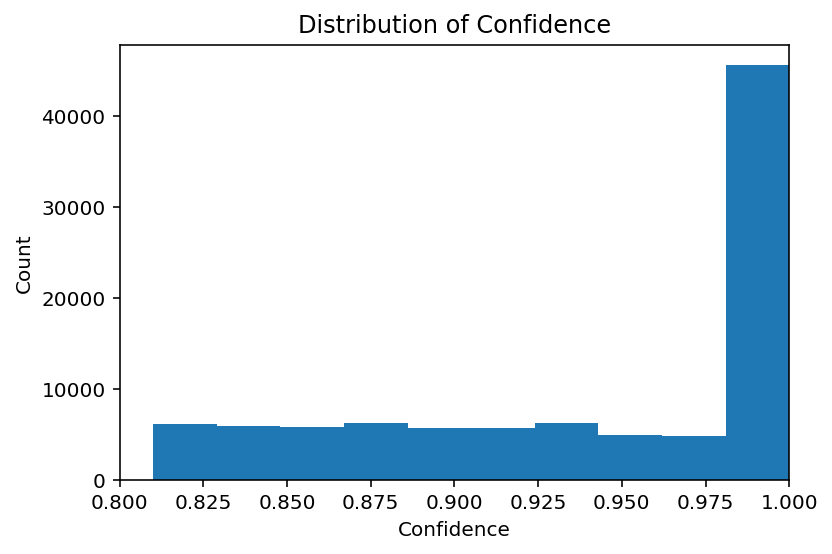

In [27]:
_ = plt.title("Distribution of Confidence")
_ = plt.xlabel("Confidence")
_ = plt.ylabel("Count")
_ = plt.xlim(0.8, 1.0)
_ = plt.hist(df['confidence'].values)

Based on this distribution and our filtering procedure, we can be confident in our analysis that the majority of our data points truly represent wildfires.

Next, we can look at the Fire Radiative Power variable's distribution to get a sense of how strong fires were between 2010 and 2016.

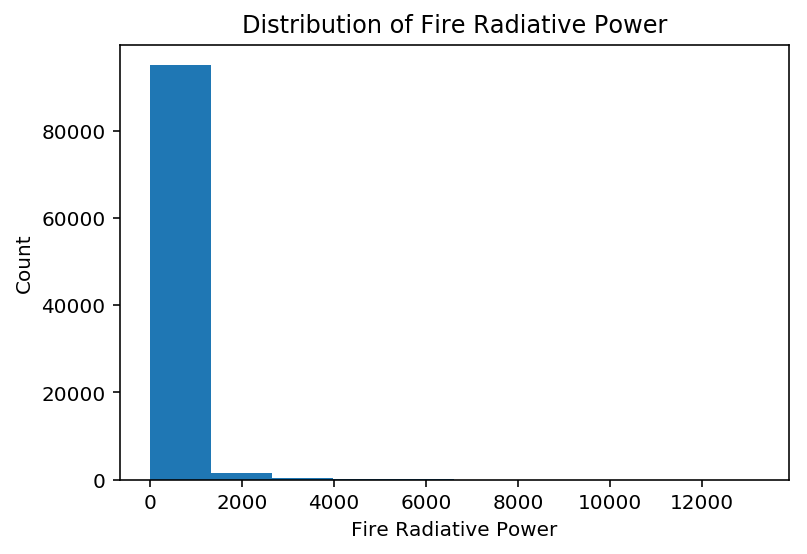

In [28]:
_ = plt.title("Distribution of Fire Radiative Power")
_ = plt.xlabel("Fire Radiative Power")
_ = plt.ylabel("Count")
_ = plt.hist(df['frp'].values)

This plot is not very helpful. We can tell that the overwhelming amount of our data points come from fires with low FRP values, but there is clearly some data that is not easily visible on this plot. Perhaps if we log scale the y-axis it will be more informative.

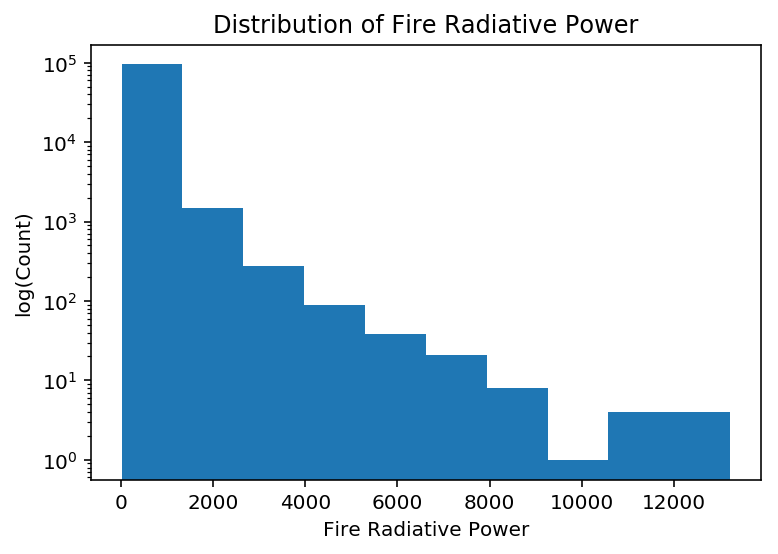

In [29]:
_ = plt.title("Distribution of Fire Radiative Power")
_ = plt.xlabel("Fire Radiative Power")
_ = plt.ylabel("log(Count)")
_ = plt.hist(df['frp'].values, log=True)

We can create these same histograms for the `vpd`, `temp`, and `humidity` variables:

/Users/markkeller/miniconda3/envs/cmsc320-final-project/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/markkeller/miniconda3/envs/cmsc320-final-project/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


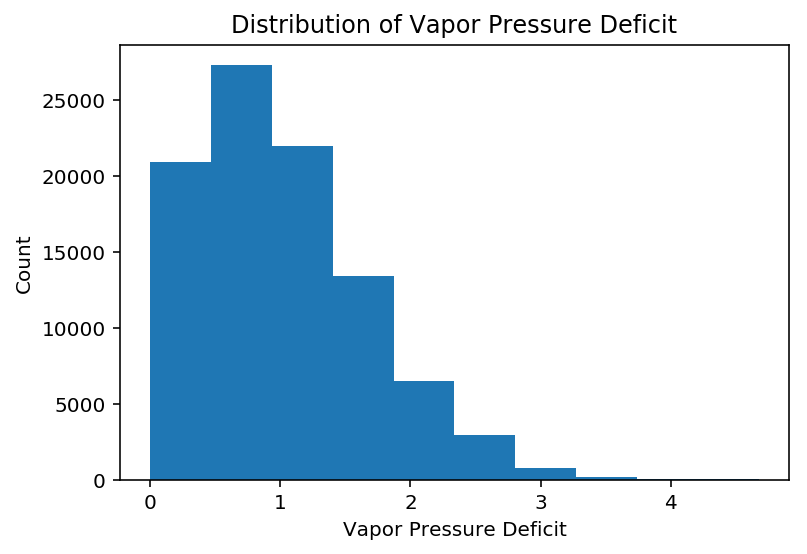

In [30]:
_ = plt.title("Distribution of Vapor Pressure Deficit")
_ = plt.xlabel("Vapor Pressure Deficit")
_ = plt.ylabel("Count")
_ = plt.hist(df['vpd'].values)

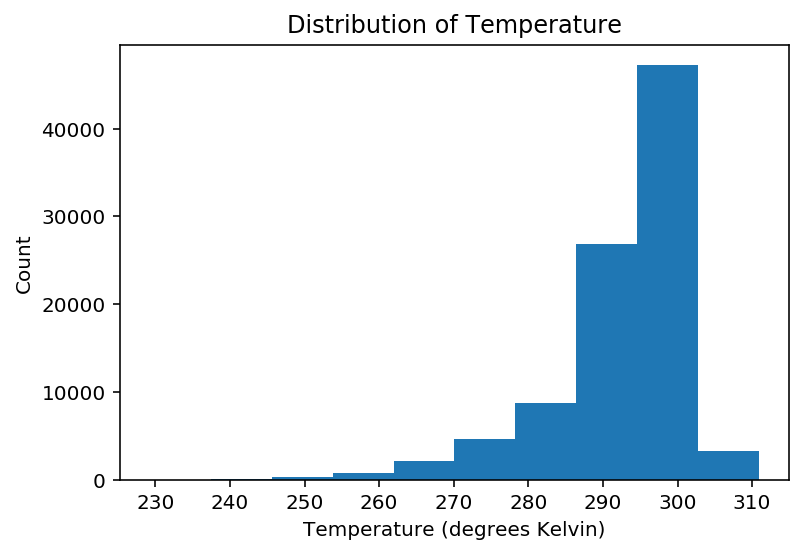

In [31]:
_ = plt.title("Distribution of Temperature")
_ = plt.xlabel("Temperature (degrees Kelvin)")
_ = plt.ylabel("Count")
_ = plt.hist(df['temp'].values)

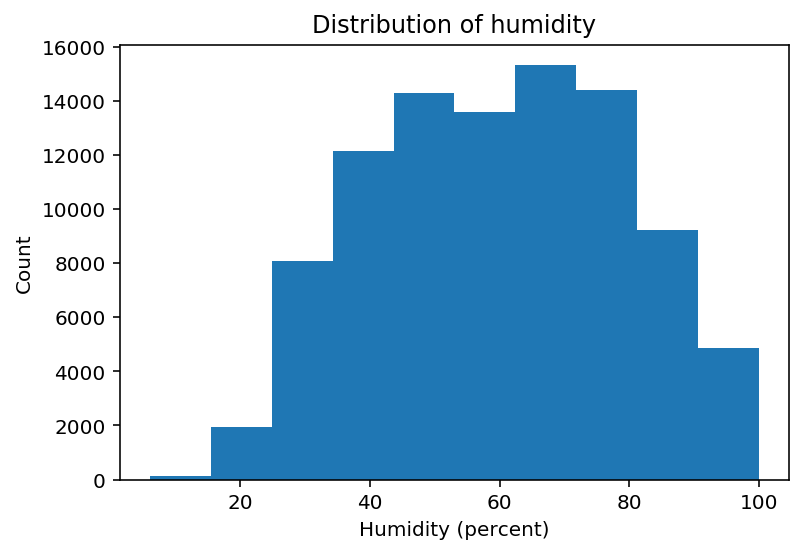

In [32]:
_ = plt.title("Distribution of humidity")
_ = plt.xlabel("Humidity (percent)")
_ = plt.ylabel("Count")
_ = plt.hist(df['humidity'].values)

Next, we can look at the distribution over time using the `year` variable. To create this histogram we will want to bin by year rather than allowing matplotlib to choose the bins automatically, so we can use pandas `groupby` to get the counts per year explicitly:

In [33]:
year_df = df.groupby(['year']).size().reset_index(name='count')
year_df.head()

year  count
0  2010   5302
1  2011   7334
2  2012  24686
3  2013  13861
4  2014  12416

Note that now that we have the explicit counts we can use the matplotlib `bar` rather than `hist`.

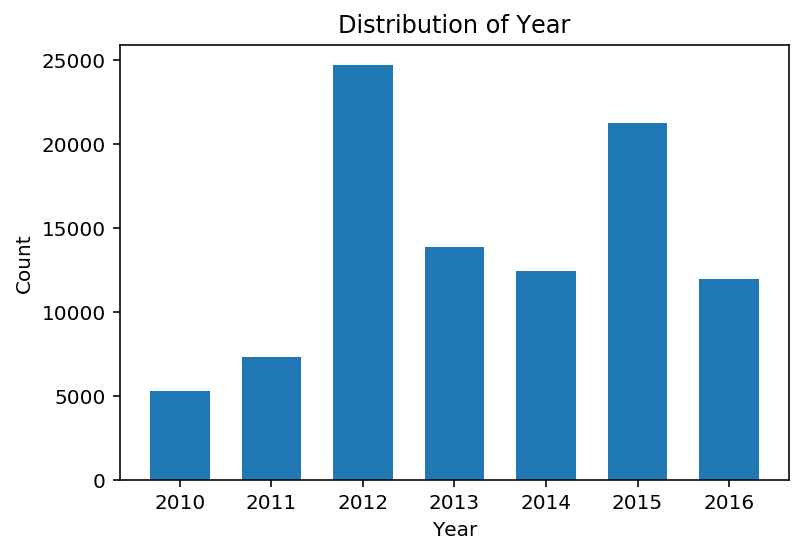

In [34]:
_ = plt.title("Distribution of Year")
_ = plt.xlabel("Year")
_ = plt.ylabel("Count")
_ = plt.bar(year_df['year'].values, year_df['count'].values, 0.65)

Next, we can look at the distribution over the year using the `dayofyear` variable.

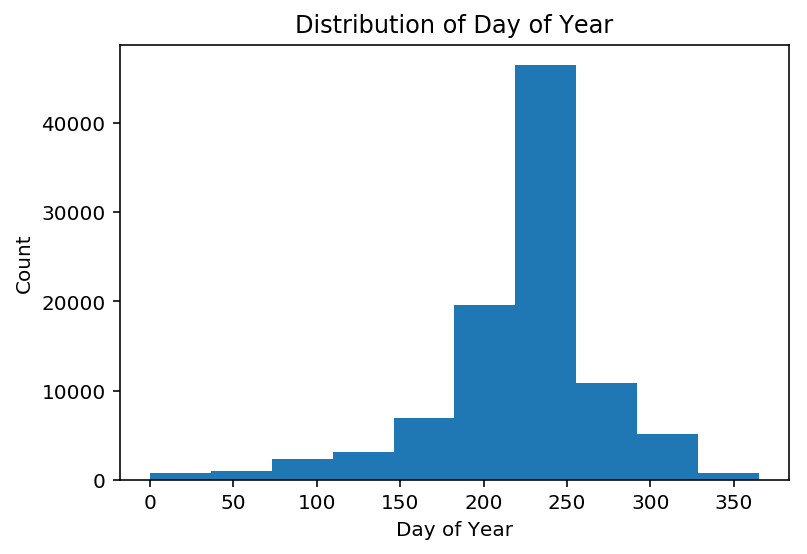

In [35]:
_ = plt.title("Distribution of Day of Year")
_ = plt.xlabel("Day of Year")
_ = plt.ylabel("Count")
_ = plt.hist(df['dayofyear'].values)

This plot shows that our distribution is fairly symmetric and unimodal, centered around day 225/365. But maybe the distribution will be more clear if we are able to view this data by month rather than day.

`datetime` can be used to format our month numbers into month names by creating a date object with our month number and then specifying an output date string format that only consists of the month name.

In [36]:
def month_num_to_name(month_num):
    date = datetime.date(2018, month_num, 1)
    return date.strftime('%B')

We will obtain counts of fires per month using pandas `groupby`.

In [37]:
month_df = df.groupby(['month']).size().reset_index(name='count')
month_df['month'] = month_df['month'].apply(month_num_to_name)

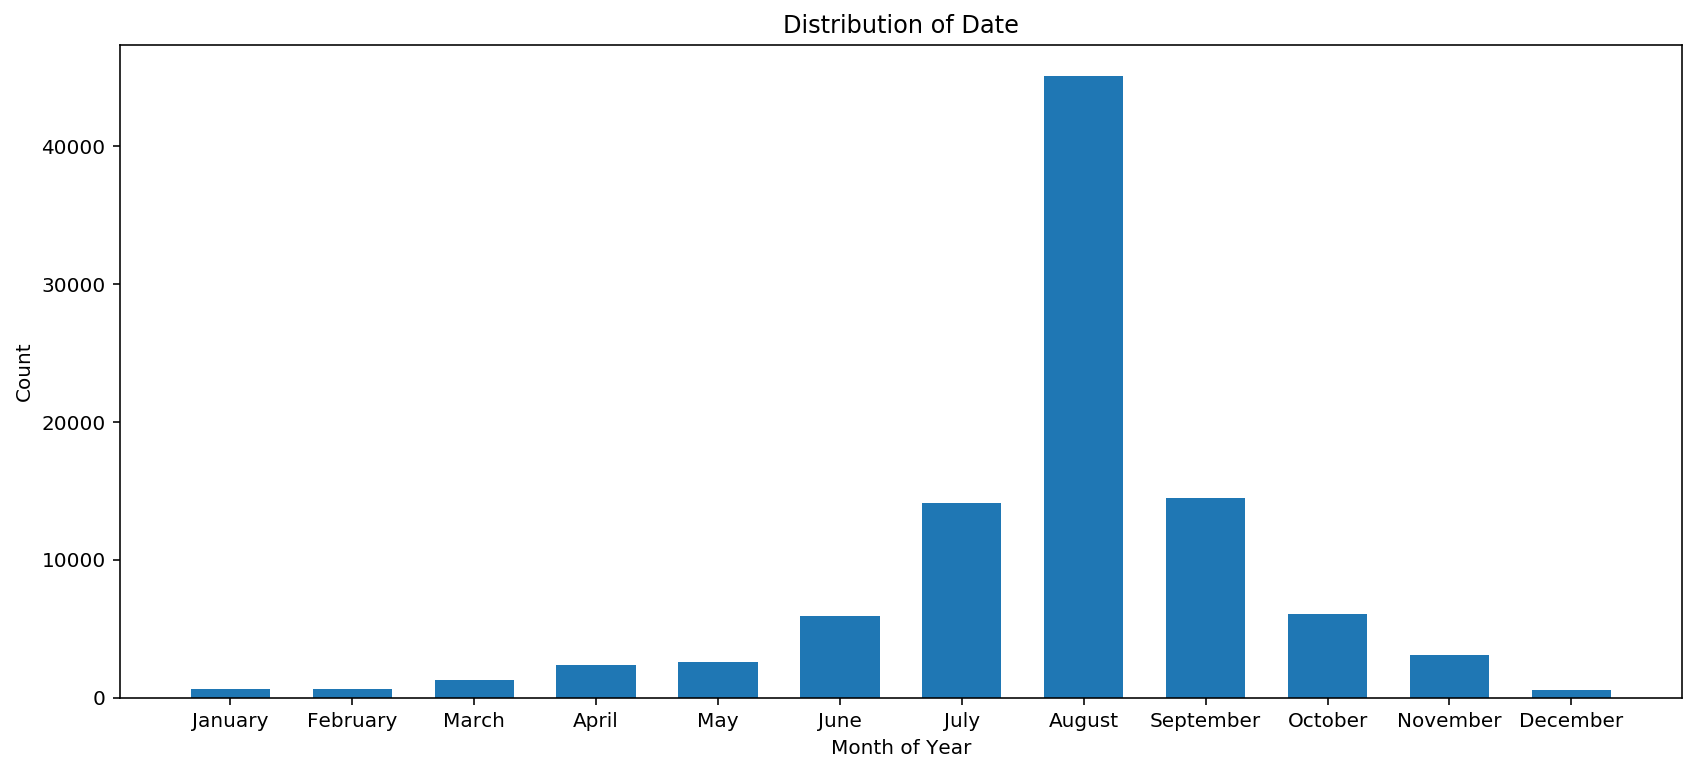

In [38]:
_ = plt.figure(figsize=(14, 6))
_ = plt.title("Distribution of Date")
_ = plt.xlabel("Month of Year")
_ = plt.ylabel("Count")
bar_width = 0.65
_ = plt.bar(month_df['month'].values, month_df['count'].values, bar_width)

Finally we can look at the entire span of time from 2010 to 2016 and count the fires observed each month.

In [39]:
year_month_df = df.groupby(['year', 'month']).size().reset_index(name='count')
year_month_df['year-month'] = year_month_df.apply(lambda row: ("%s %i" % (month_num_to_name(row['month']), row['year'])), axis='columns')
year_month_df.head()

year  month  count     year-month
0  2010      1     18   January 2010
1  2010      2     49  February 2010
2  2010      3    172     March 2010
3  2010      4    213     April 2010
4  2010      5    147       May 2010

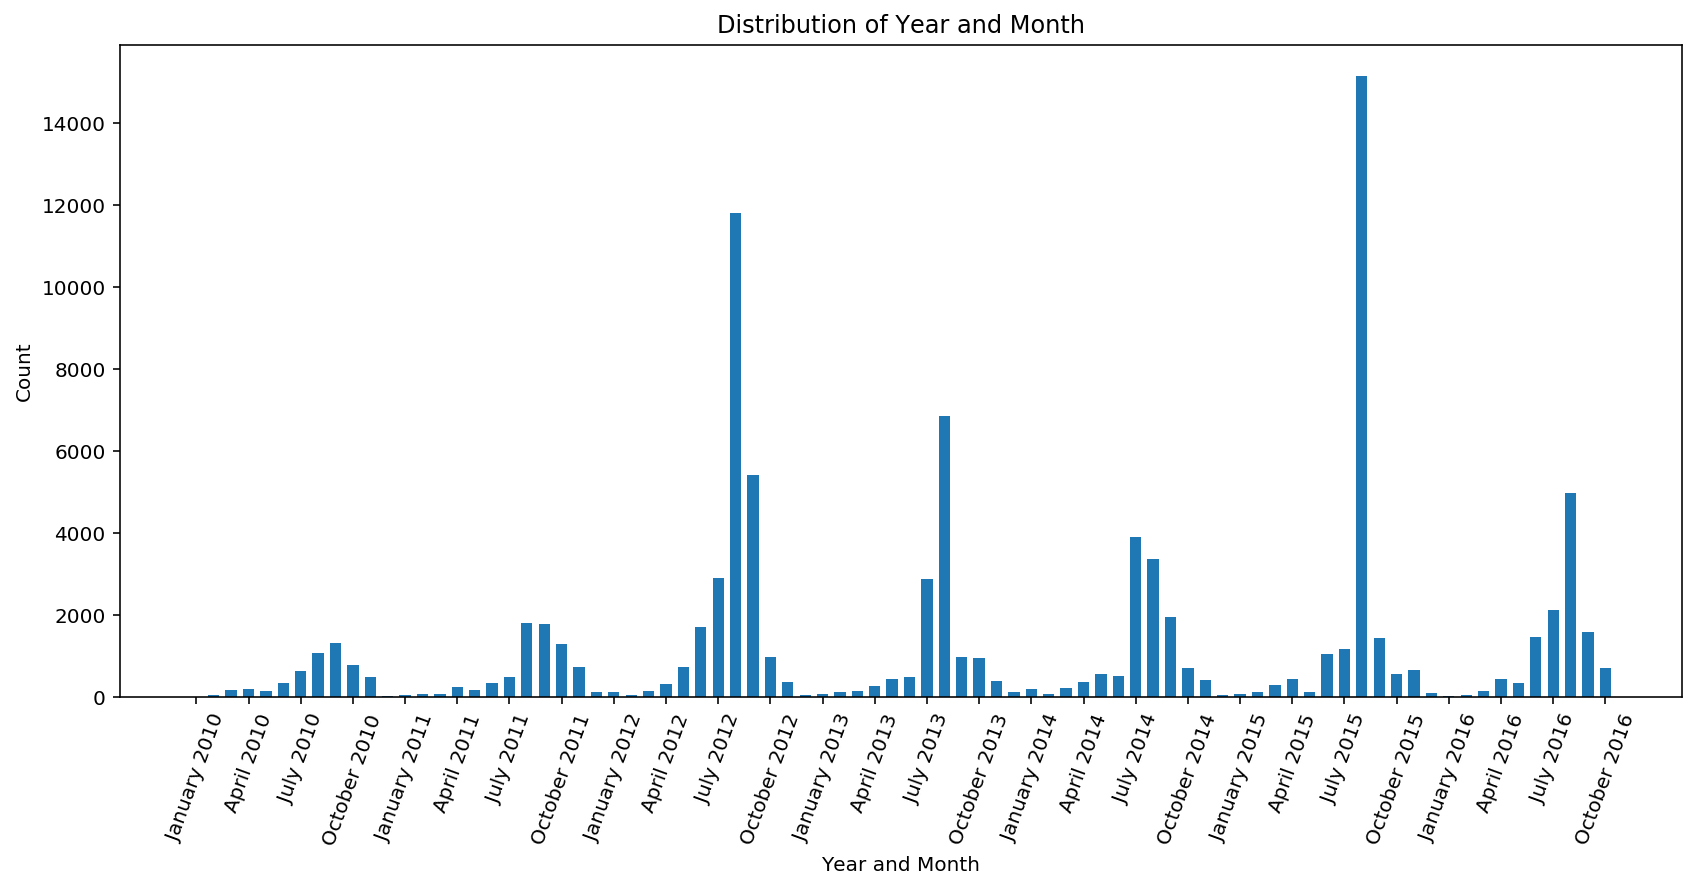

In [40]:
_ = plt.figure(figsize=(14, 6))
_ = plt.title("Distribution of Year and Month")
_ = plt.xlabel("Year and Month")
_ = plt.ylabel("Count")
_ = plt.bar(year_month_df['year-month'].values, year_month_df['count'].values, 0.65)
_ = plt.xticks(year_month_df['year-month'].values[::3], rotation=70)

### 3.2 Multivariate Analysis

Because this wildfire data also contains location data, we can view it on a map as well. We will begin our multivariate analysis by looking at the location data in relationship to other variables.

To do so, we will load python packages to assist with geographical data visualization
- `cartopy`: geographical visualization toolkit for matplotlib

In [41]:
import cartopy.crs as ccrs
#from cartopy.io.img_tiles import OSM
from cartopy.io.img_tiles import Stamen
imagery = Stamen(style='terrain-background')

To determine the extent (ranges) of our maps, we can determine the range of the latitude and longitude variables in the wildfire dataset.

In [42]:
min_lon = df['lon'].min()
max_lon = df['lon'].max()
min_lon -= (max_lon - min_lon) * 0.2
min_lat = df['lat'].min()
max_lat = df['lat'].max()

For our visualization, we will plot fires from different years using different colors. To do so, matplotlib's colormap module can be used to map each year to a color of the rainbow. 

We will make this conventient for ourselves later by creating a function that will generalize this mapping to any sorted array.

In [43]:
def get_cmap_dict(vals, cmap_name='rainbow', numeric=True):
    cmap = cm.get_cmap(cmap_name)
    if numeric:
        # assume vals already sorted
        min_val = vals[0]
        max_val = vals[-1]
        return dict(zip(vals, [cmap((val - min_val) / (max_val - min_val)) for val in vals]))
    else:
        len_vals = len(vals)
        return dict(zip(vals, [cmap(val / len_vals) for val in range(len_vals)]))

In [44]:
years = list(df['year'].unique())
year_to_color_map = get_cmap_dict(years)

Because the plot could become cluttered and difficult to interpret, we will first restrict the fires to those with the top strength (`frp`) for each year.

In [45]:
n_per_year = 30
df_top_frp = df.sort_values(['frp'], ascending=False)
df_top_frp_year_groupby = df_top_frp.groupby(['year'])

Next we will need to determine the minimum and maximum strength values, which will help us to make a legend.

In [46]:
min_frp = df_top_frp_year_groupby.min()['frp'].min()
max_frp = df_top_frp_year_groupby.max()['frp'].max()
frp_intervals = np.linspace(max_frp, min_frp, 4, endpoint=False)

Now we will create the plot.

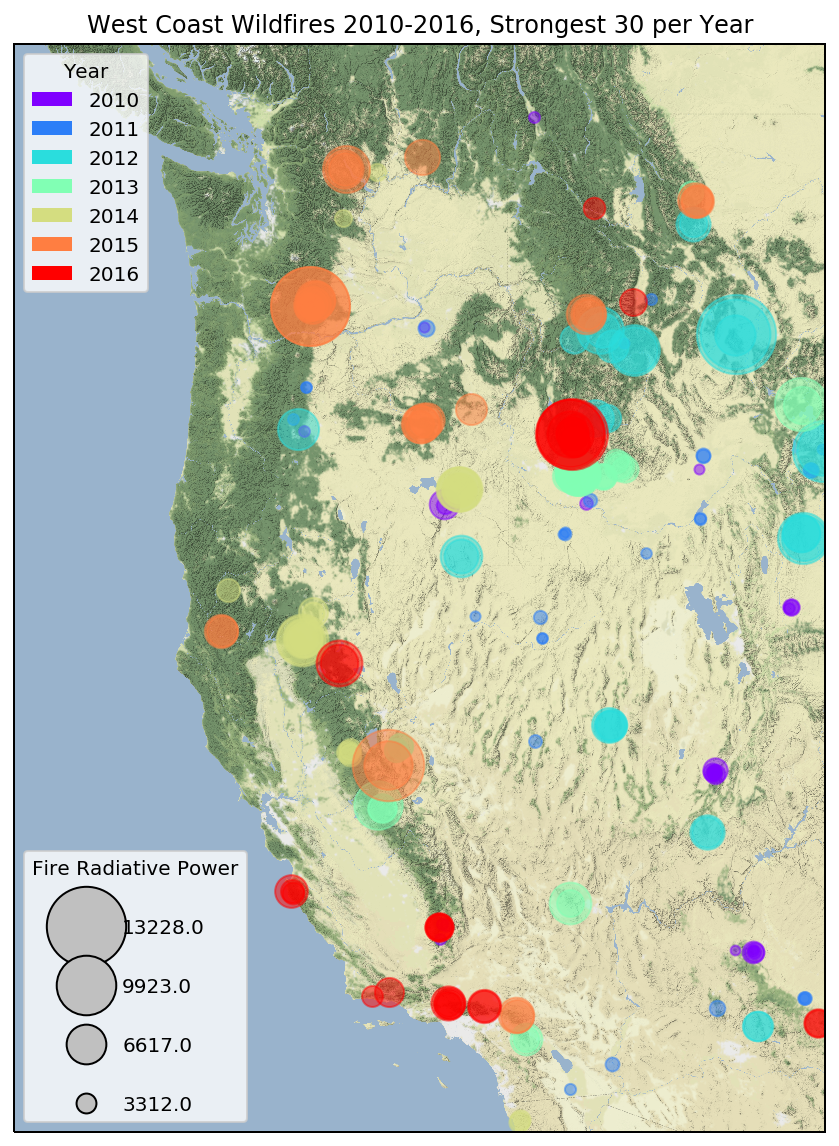

In [47]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection=imagery.crs)
_ = ax.set_extent([min_lon, max_lon, min_lat, max_lat], ccrs.PlateCarree())
_ = ax.add_image(imagery, 8)
frp_scaling_factor = 0.003
for year, df_top_frp_year in df_top_frp_year_groupby:
    for index, row in df_top_frp_year.head(n_per_year).iterrows():
        _ = plt.plot(
            row['lon'], 
            row['lat'], 
            marker='o', 
            color=year_to_color_map[row['year']], 
            markersize=(frp_scaling_factor*row['frp']), 
            alpha=0.5, 
            transform=ccrs.Geodetic()
        )
_ = ax.set_title("West Coast Wildfires 2010-2016, Strongest %i per Year" % n_per_year)

year_legend_elements = [Patch(facecolor=year_color, label=year) for year, year_color in year_to_color_map.items()]
year_legend = ax.legend(handles=year_legend_elements, loc='upper left', title='Year')
_ = plt.gca().add_artist(year_legend)

frp_legend_elements = [Line2D([0], [0], marker='o', color=(0,0,0,0), label=np.floor(frp_val), markerfacecolor='#C0C0C0', markersize=frp_val*frp_scaling_factor) for frp_val in frp_intervals]
_ = ax.legend(handles=frp_legend_elements, loc='lower left', labelspacing=2, columnspacing=2, title='Fire Radiative Power')

Next we can perform multivariate analysis of the rest of our data and ask ourselves whether we see relationships between any of our variables.

In the following plot we will look at temperature over time.

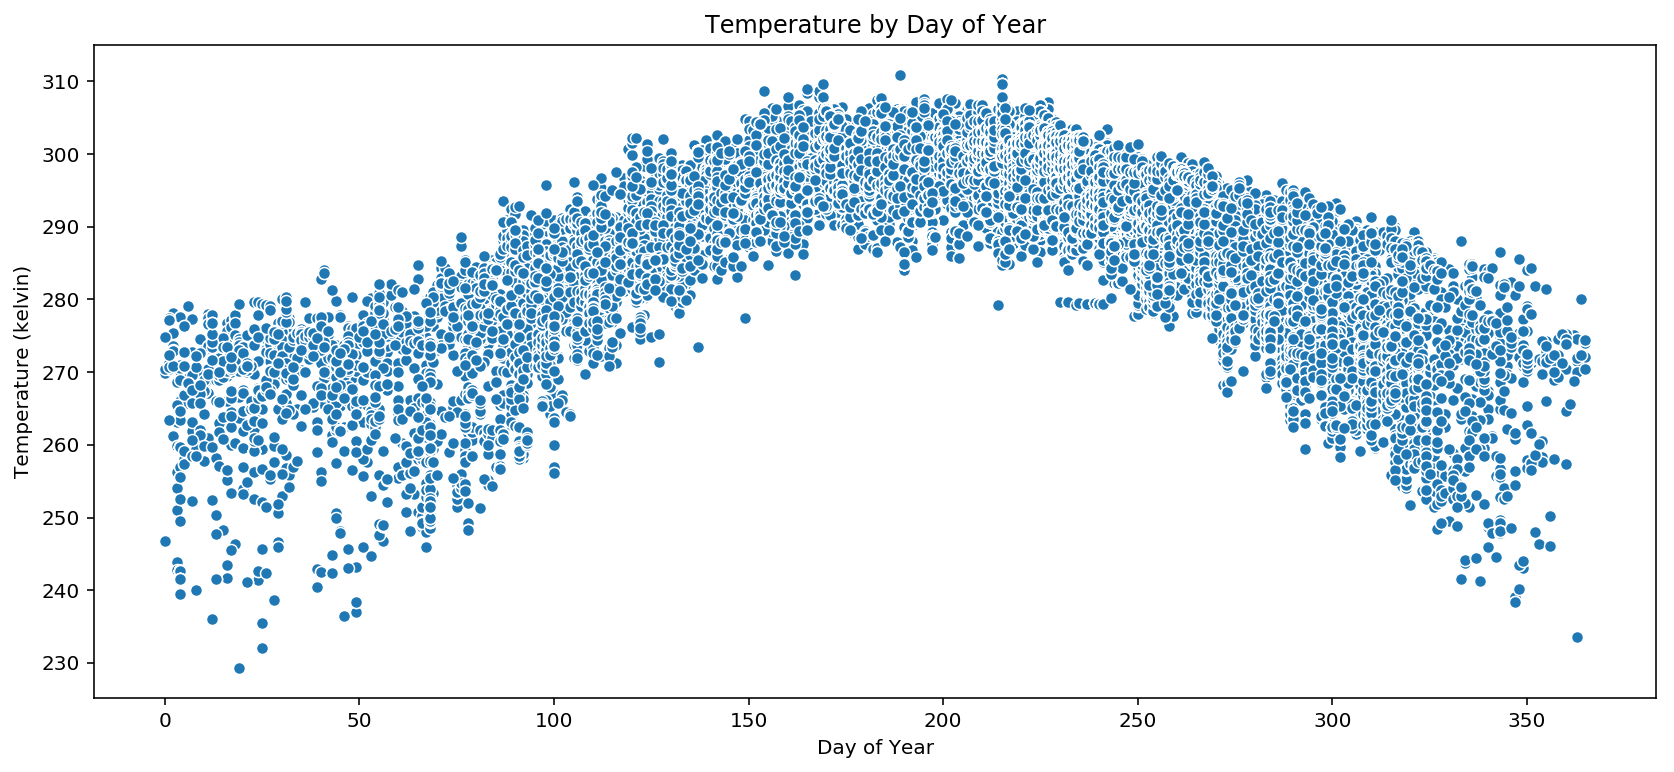

In [48]:
_ = plt.figure(figsize=(14, 6))
_ = plt.title("Temperature by Day of Year")
_ = sns.scatterplot(x="dayofyear", y="temp", data=df)
_ = plt.xlabel("Day of Year")
_ = plt.ylabel("Temperature (kelvin)")

Next, we can incorporate year by coloring each point based on year.

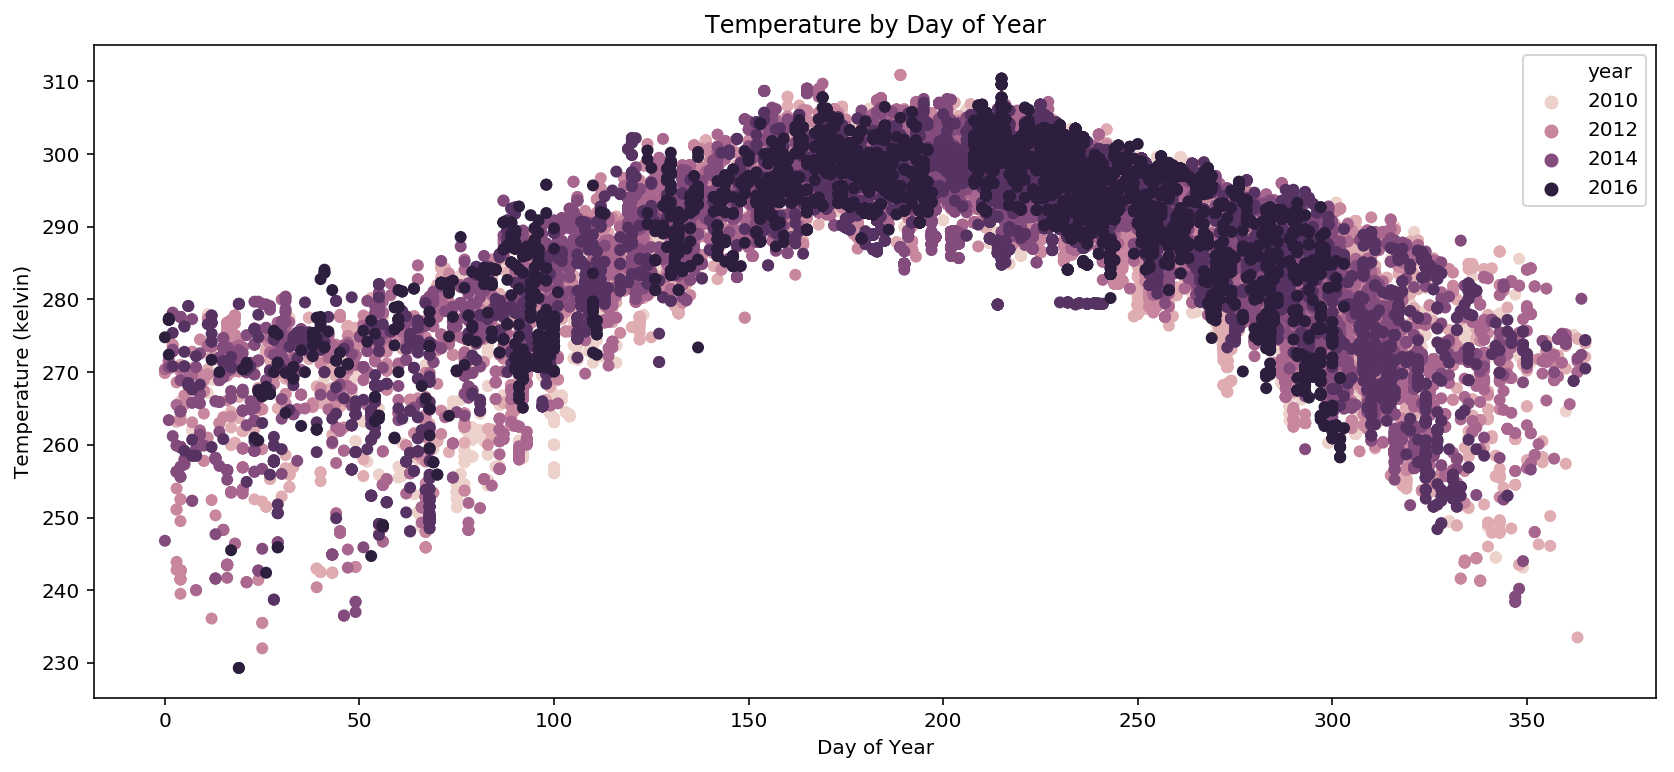

In [49]:
_ = plt.figure(figsize=(14, 6))
_ = plt.title("Temperature by Day of Year")
_ = sns.scatterplot(x="dayofyear", y="temp", hue="year", data=df, linewidth=0)
_ = plt.xlabel("Day of Year")
_ = plt.ylabel("Temperature (kelvin)")

It might be easier to look at the means for each year.

In [50]:
year_dayofyear_df = df.groupby(['year', 'dayofyear']).mean().reset_index()

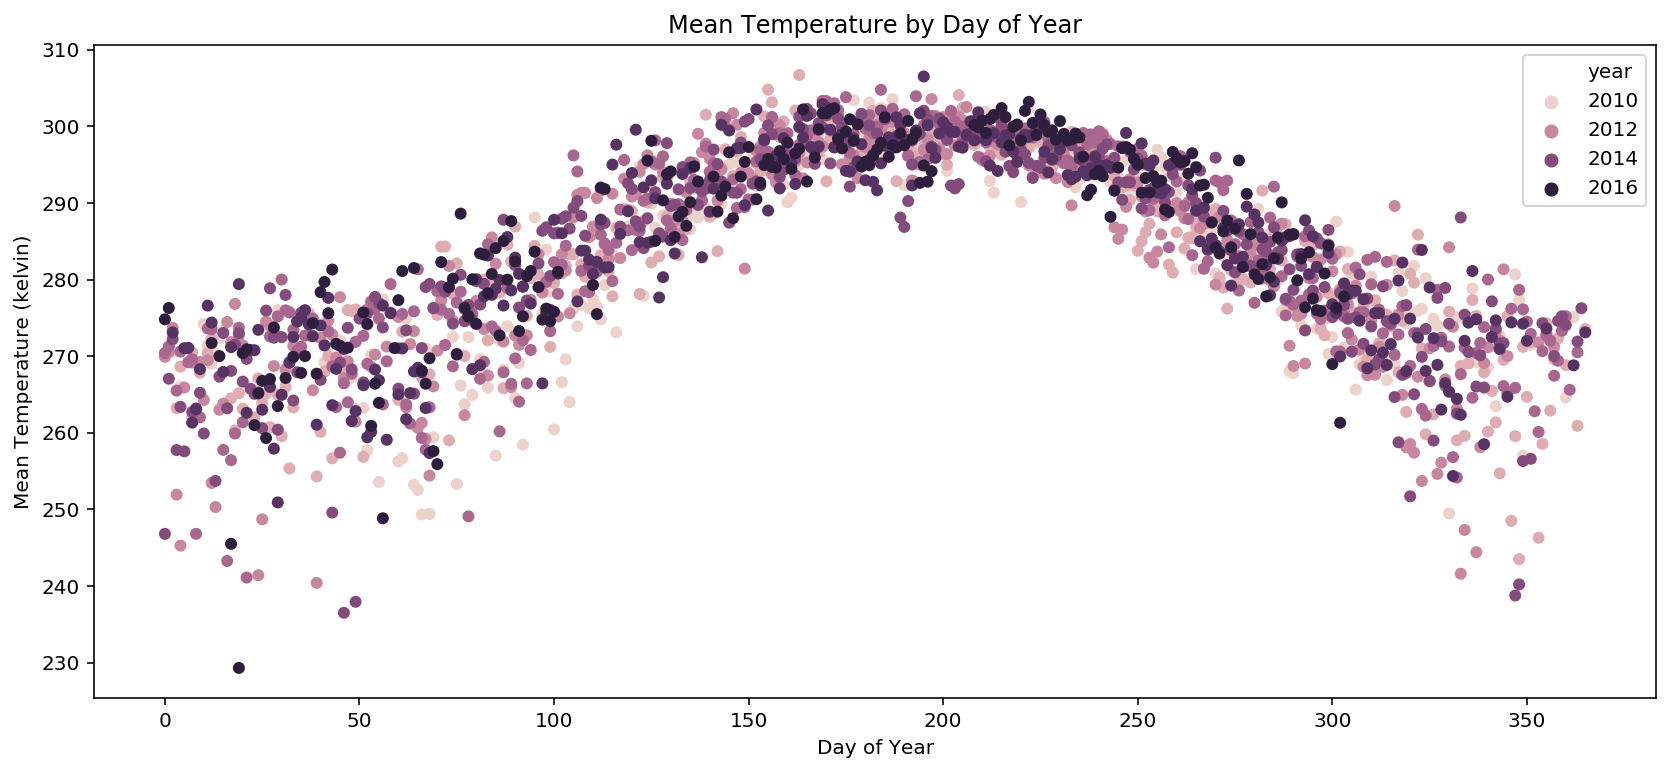

In [51]:
_ = plt.figure(figsize=(14, 6))
_ = plt.title("Mean Temperature by Day of Year")
_ = sns.scatterplot(x="dayofyear", y="temp", hue="year", data=year_dayofyear_df, linewidth=0)
_ = plt.xlabel("Day of Year")
_ = plt.ylabel("Mean Temperature (kelvin)")

In [52]:
year_month_mean_df = df.groupby(['year', 'month']).mean().reset_index()

In [53]:
month_tick_formatter = matplotlib.ticker.FuncFormatter(lambda x, p: month_num_to_name(int(x)) if x >= 1 and x <= 12 else "")

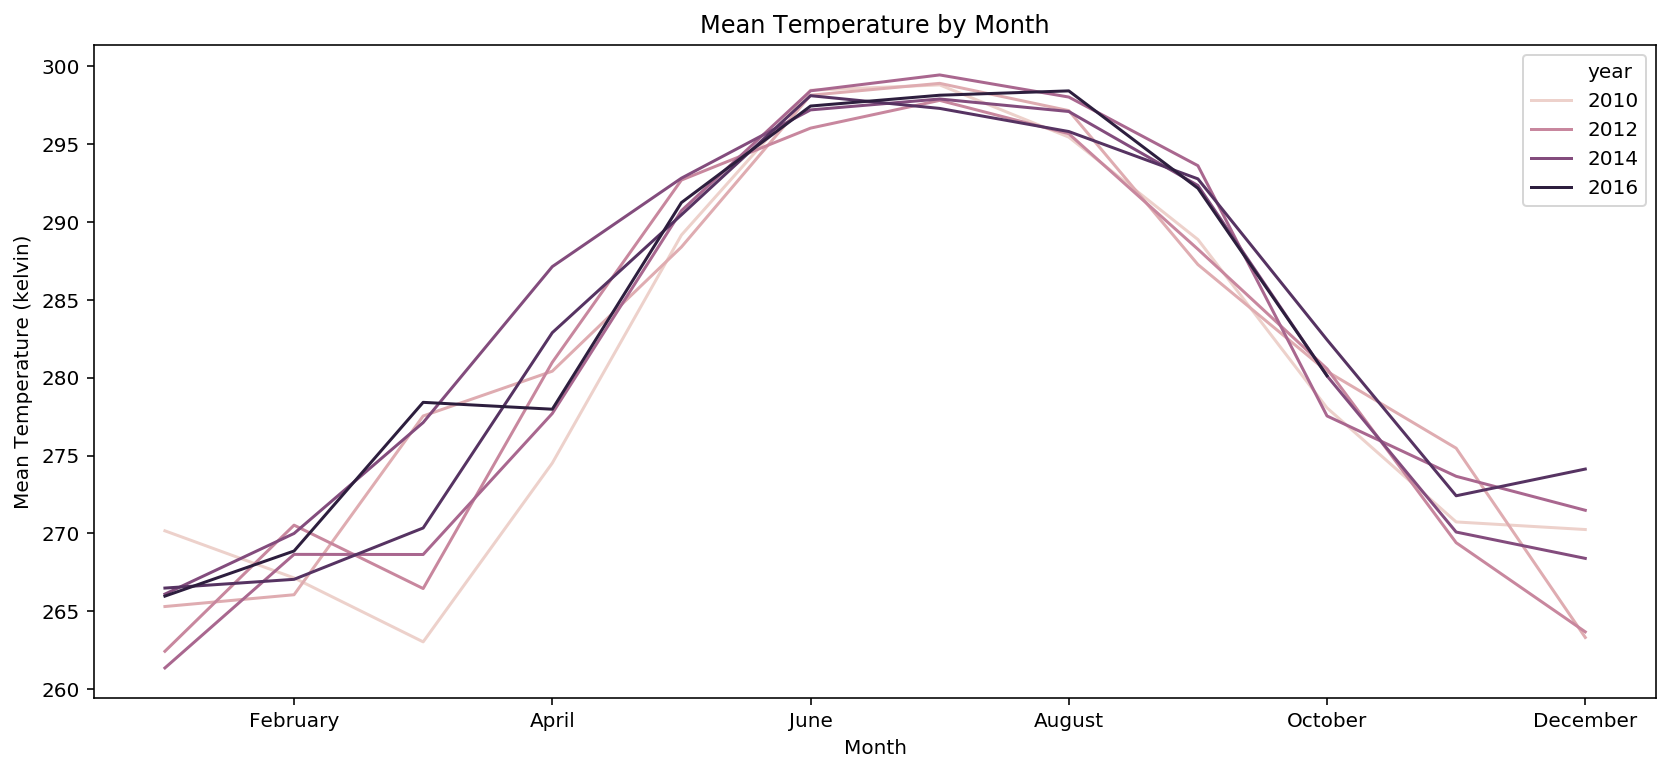

In [54]:
_ = plt.figure(figsize=(14, 6))
_ = plt.title("Mean Temperature by Month")
ax = sns.lineplot(x="month", y="temp", hue="year", data=year_month_mean_df)
_ = plt.xlabel("Month")
_ = plt.ylabel("Mean Temperature (kelvin)")
_ = ax.xaxis.set_major_formatter(month_tick_formatter)

Because we have many more variable pairs to evaluate, we can start to look at correlations.

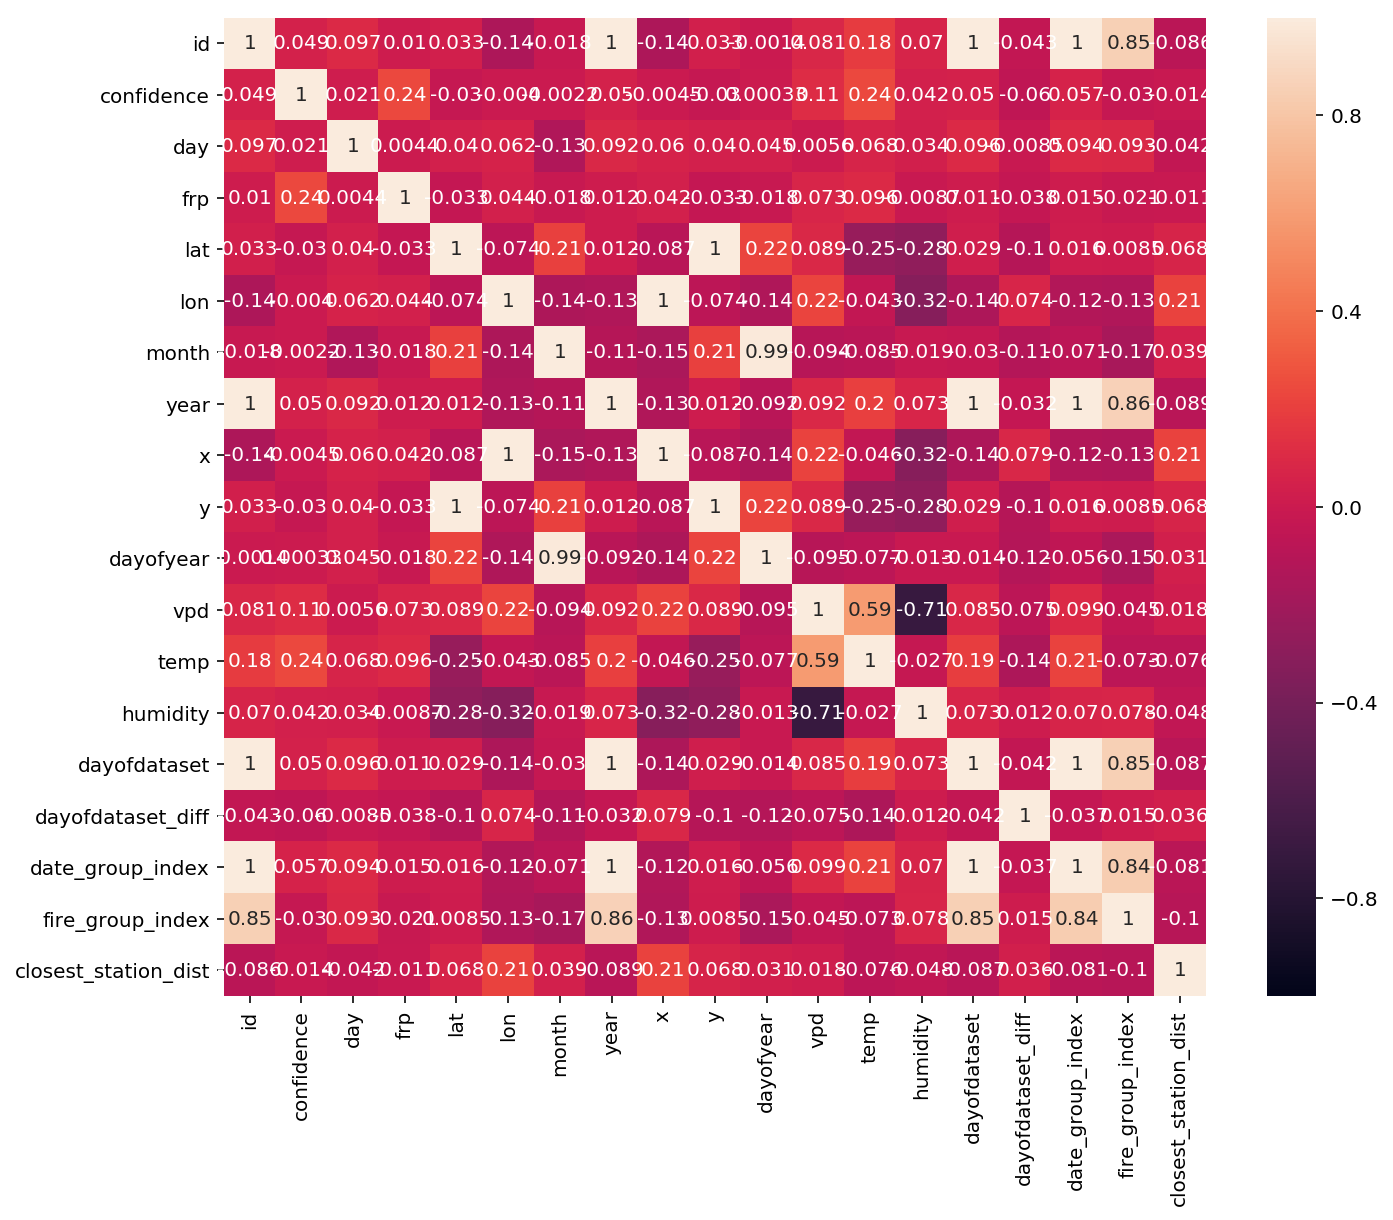

In [55]:
corr_df = df.corr()
_ = plt.figure(figsize=(11, 9))
_ = sns.heatmap(corr_df, annot=True, vmin=-1, vmax=1)

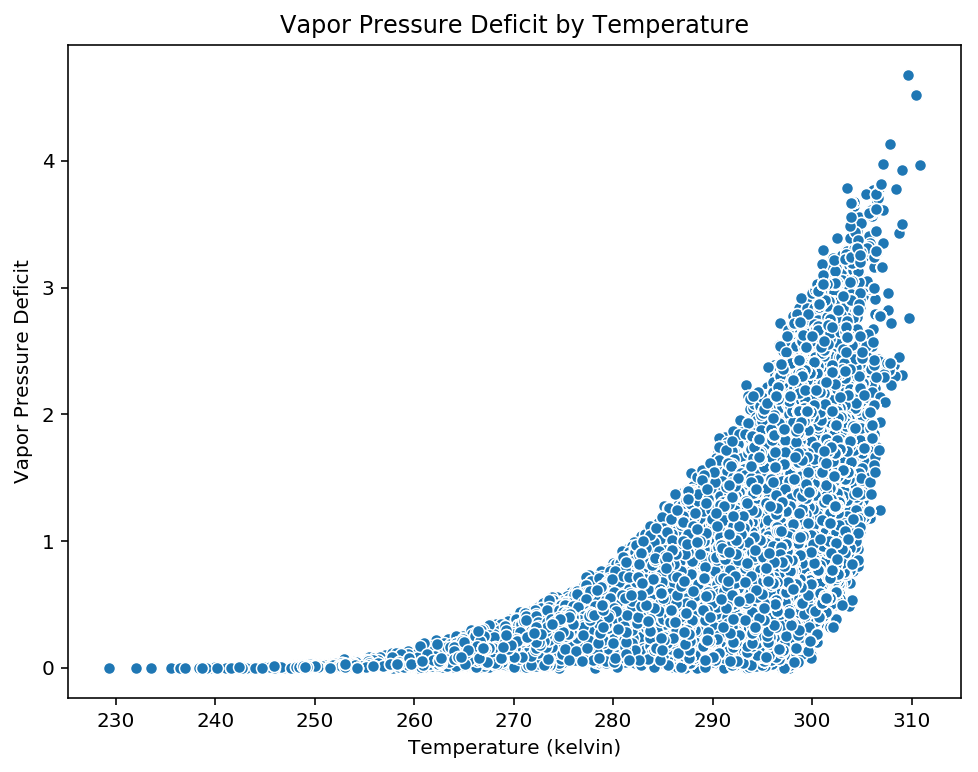

In [56]:
_ = plt.figure(figsize=(8, 6))
_ = plt.title("Vapor Pressure Deficit by Temperature")
_ = sns.scatterplot(x="temp", y="vpd", data=df)
_ = plt.xlabel("Temperature (kelvin)")
_ = plt.ylabel("Vapor Pressure Deficit")

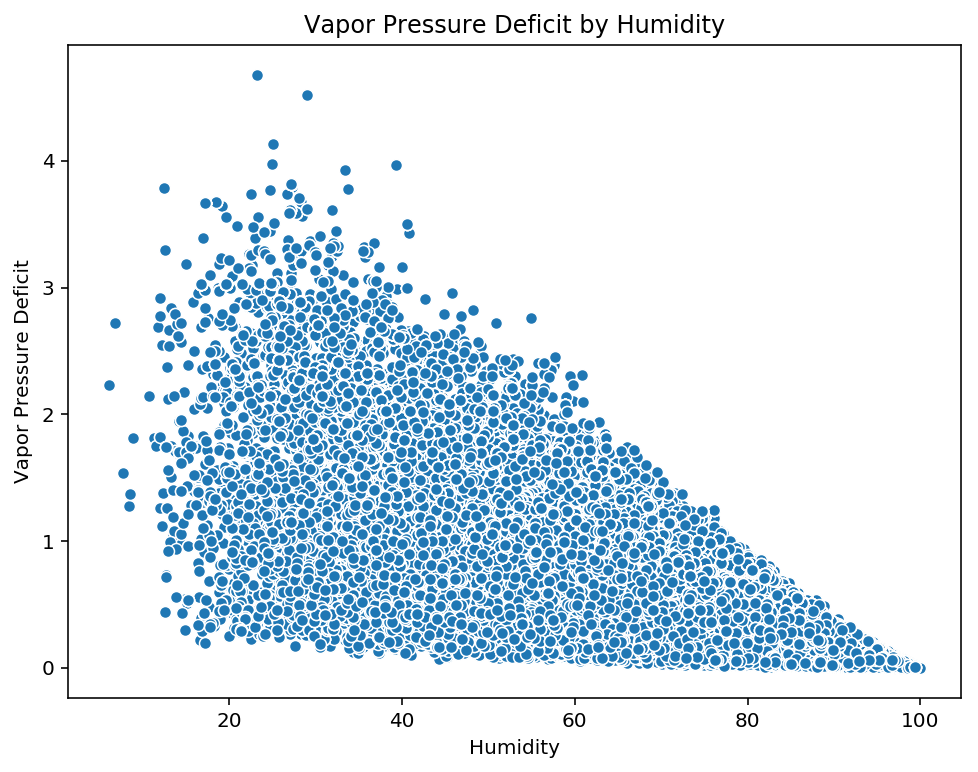

In [57]:
_ = plt.figure(figsize=(8, 6))
_ = plt.title("Vapor Pressure Deficit by Humidity")
_ = sns.scatterplot(x="humidity", y="vpd", data=df)
_ = plt.xlabel("Humidity")
_ = plt.ylabel("Vapor Pressure Deficit")

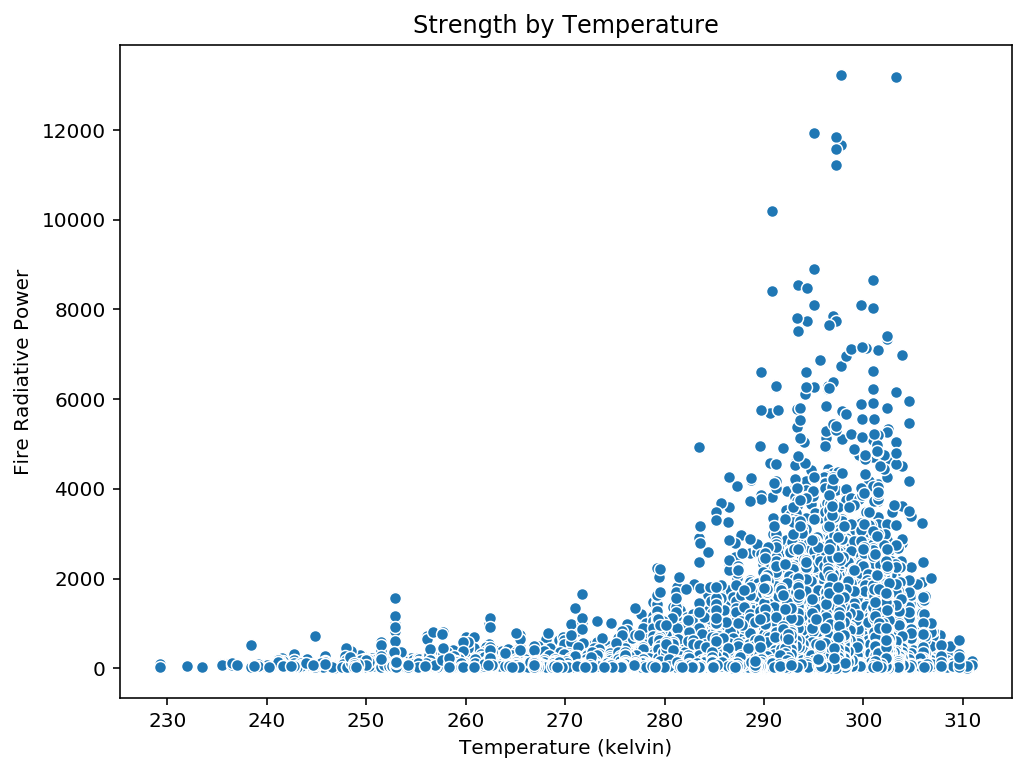

In [58]:
_ = plt.figure(figsize=(8, 6))
_ = plt.title("Strength by Temperature")
ax = sns.scatterplot(x="temp", y="frp", data=df)
_ = plt.xlabel("Temperature (kelvin)")
_ = plt.ylabel("Fire Radiative Power")

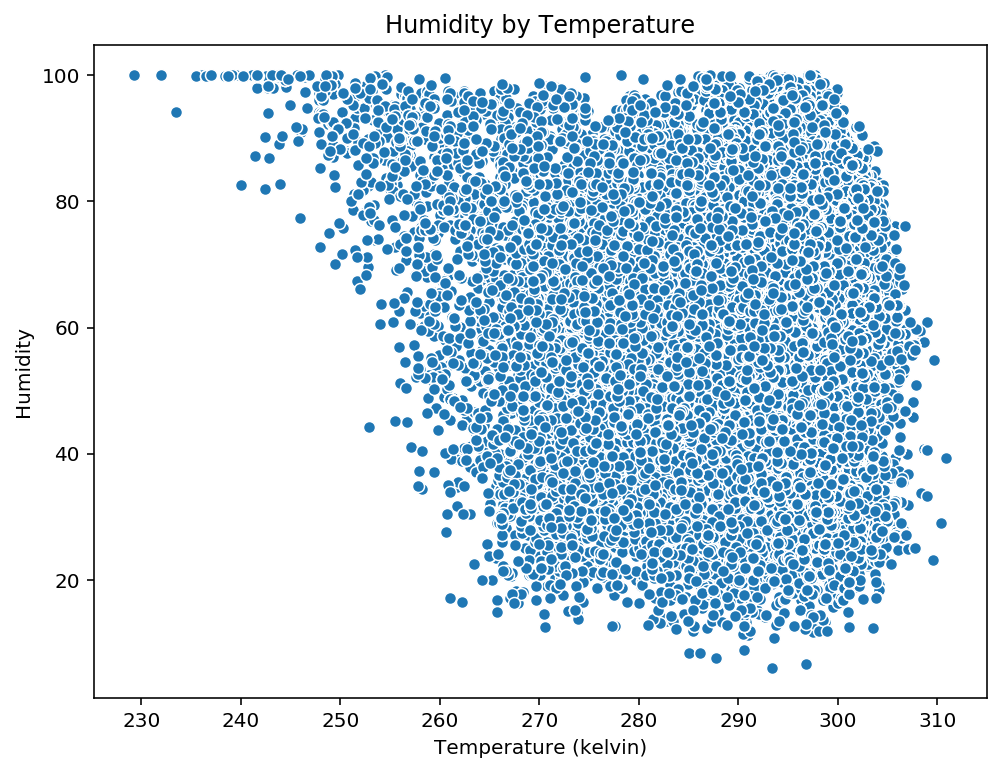

In [59]:
_ = plt.figure(figsize=(8, 6))
_ = plt.title("Humidity by Temperature")
_ = sns.scatterplot(x="temp", y="humidity", data=df)
_ = plt.xlabel("Temperature (kelvin)")
_ = plt.ylabel("Humidity")

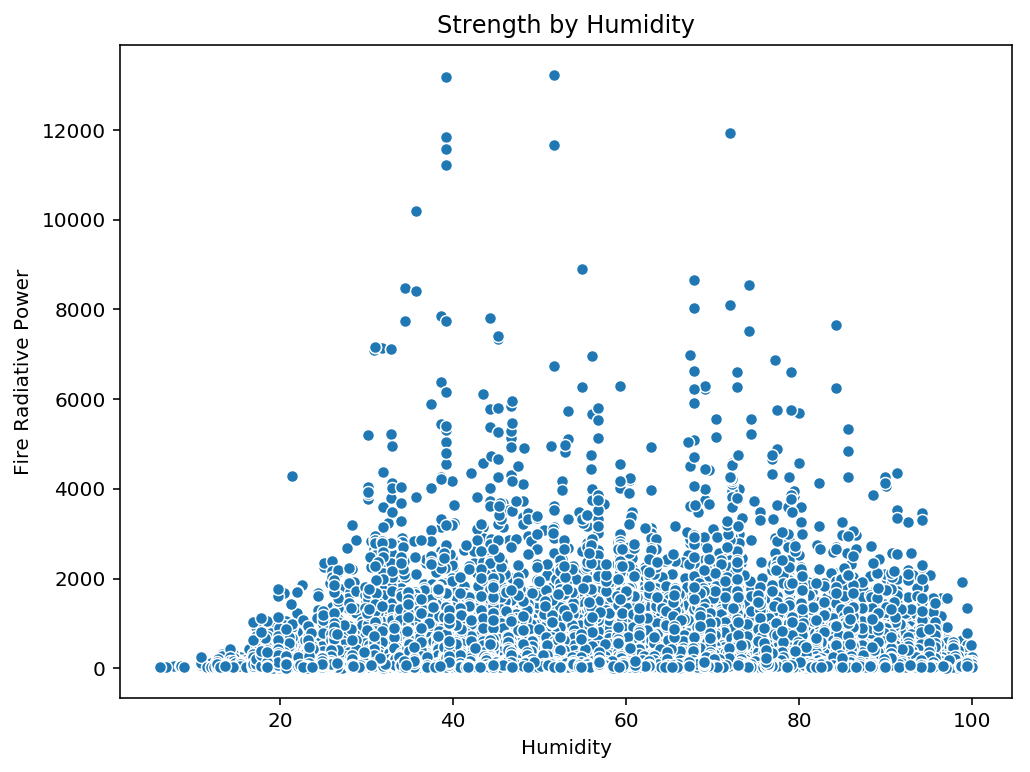

In [60]:
_ = plt.figure(figsize=(8, 6))
_ = plt.title("Strength by Humidity")
_ = sns.scatterplot(x="humidity", y="frp", data=df)
_ = plt.xlabel("Humidity")
_ = plt.ylabel("Fire Radiative Power")

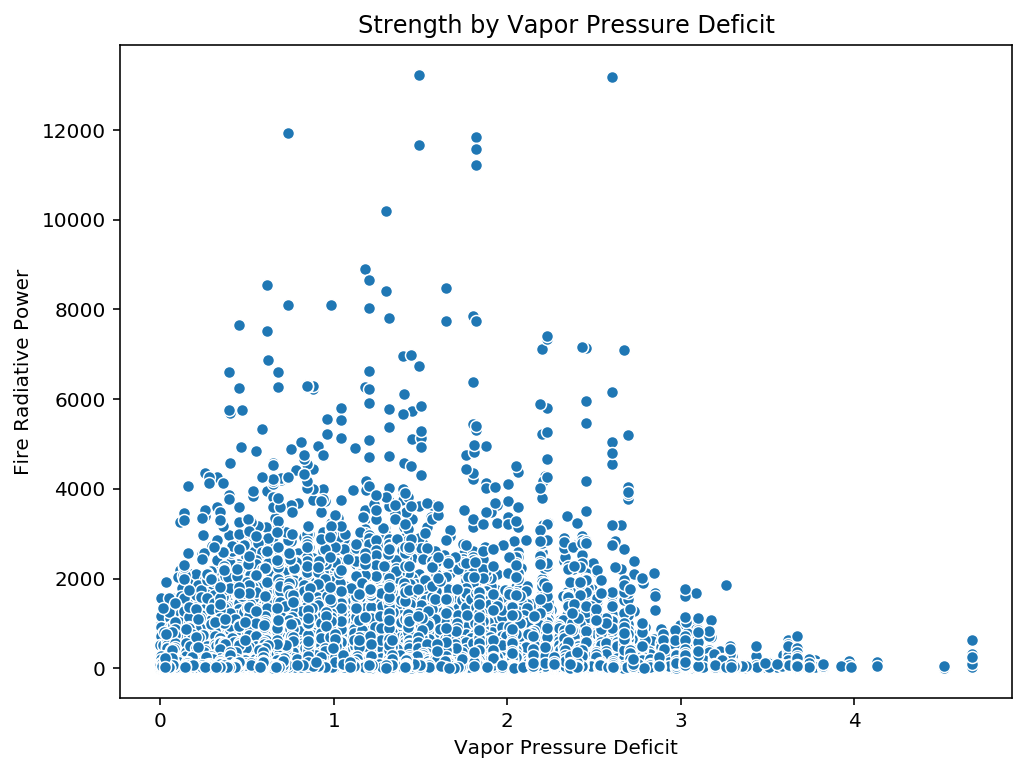

In [61]:
_ = plt.figure(figsize=(8, 6))
_ = plt.title("Strength by Vapor Pressure Deficit")
_ = sns.scatterplot(x="vpd", y="frp", data=df)
_ = plt.xlabel("Vapor Pressure Deficit")
_ = plt.ylabel("Fire Radiative Power")

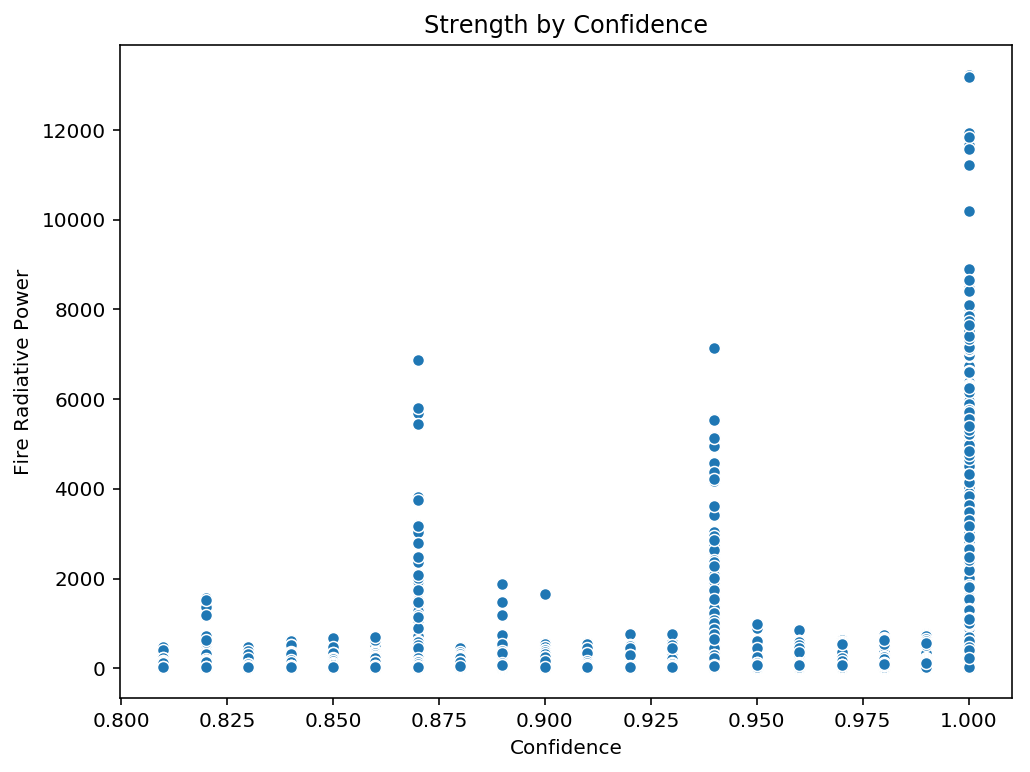

In [62]:
_ = plt.figure(figsize=(8, 6))
_ = plt.title("Strength by Confidence")
_ = sns.scatterplot(x="confidence", y="frp", data=df)
_ = plt.xlabel("Confidence")
_ = plt.ylabel("Fire Radiative Power")

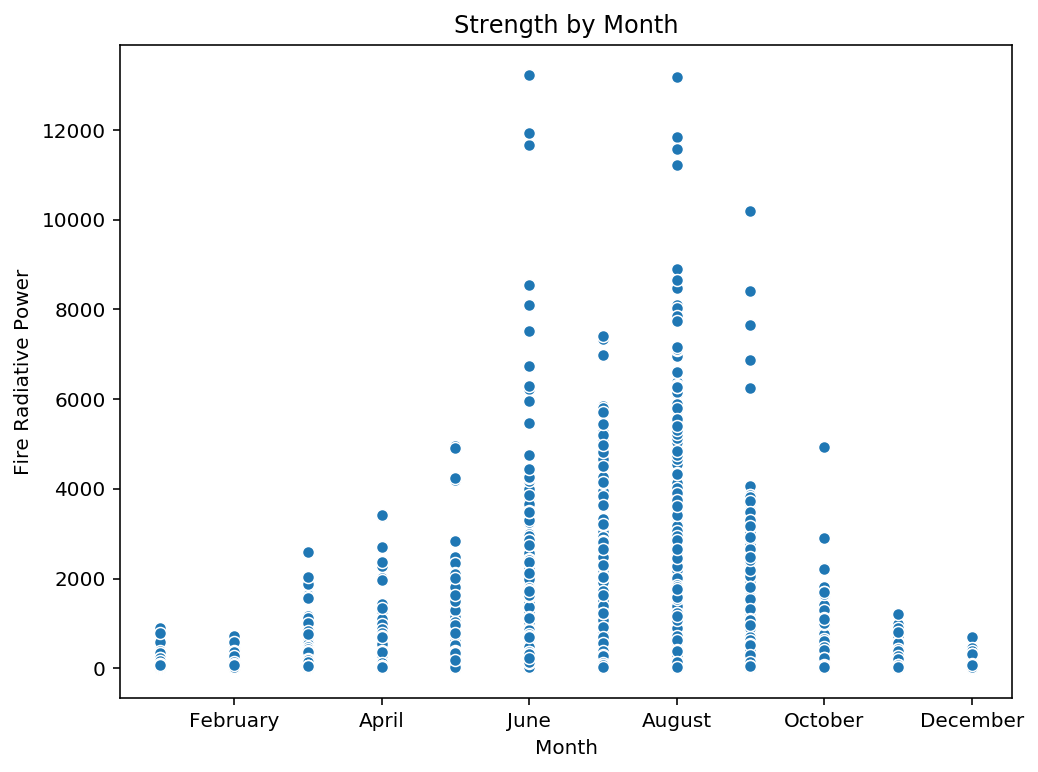

In [63]:
_ = plt.figure(figsize=(8, 6))
_ = plt.title("Strength by Month")
ax = sns.scatterplot(x="month", y="frp", data=df)
_ = plt.xlabel("Month")
_ = plt.ylabel("Fire Radiative Power")
_ = ax.xaxis.set_major_formatter(month_tick_formatter)

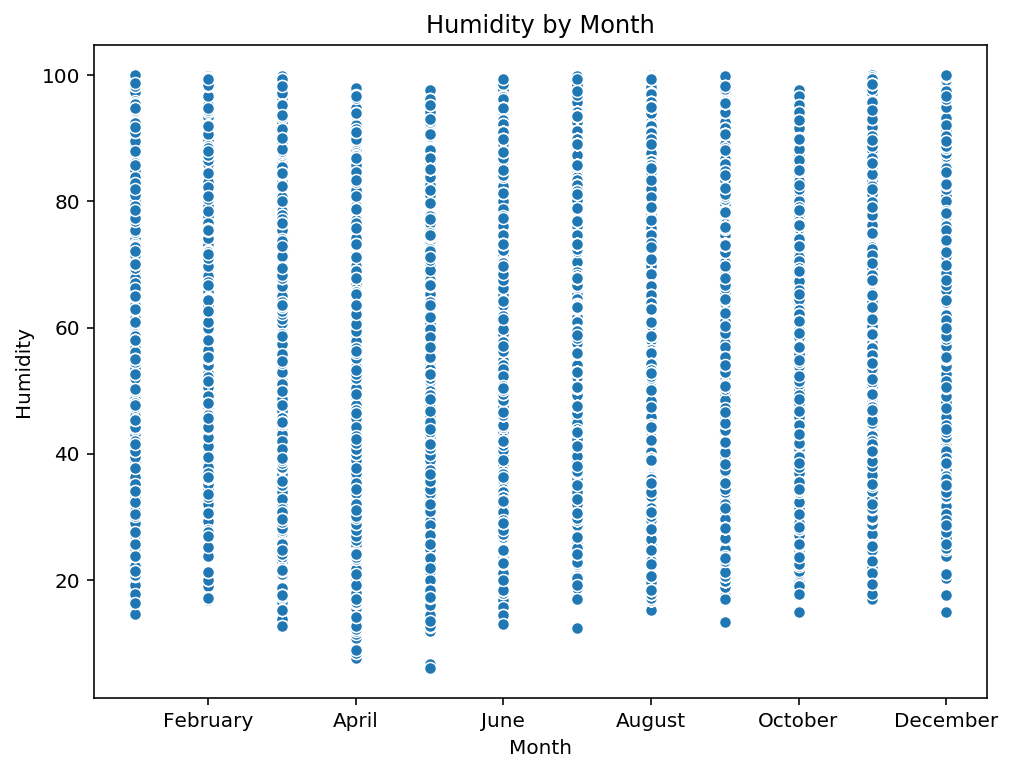

In [64]:
_ = plt.figure(figsize=(8, 6))
_ = plt.title("Humidity by Month")
ax = sns.scatterplot(x="month", y="humidity", data=df)
_ = plt.xlabel("Month")
_ = plt.ylabel("Humidity")
_ = ax.xaxis.set_major_formatter(month_tick_formatter)

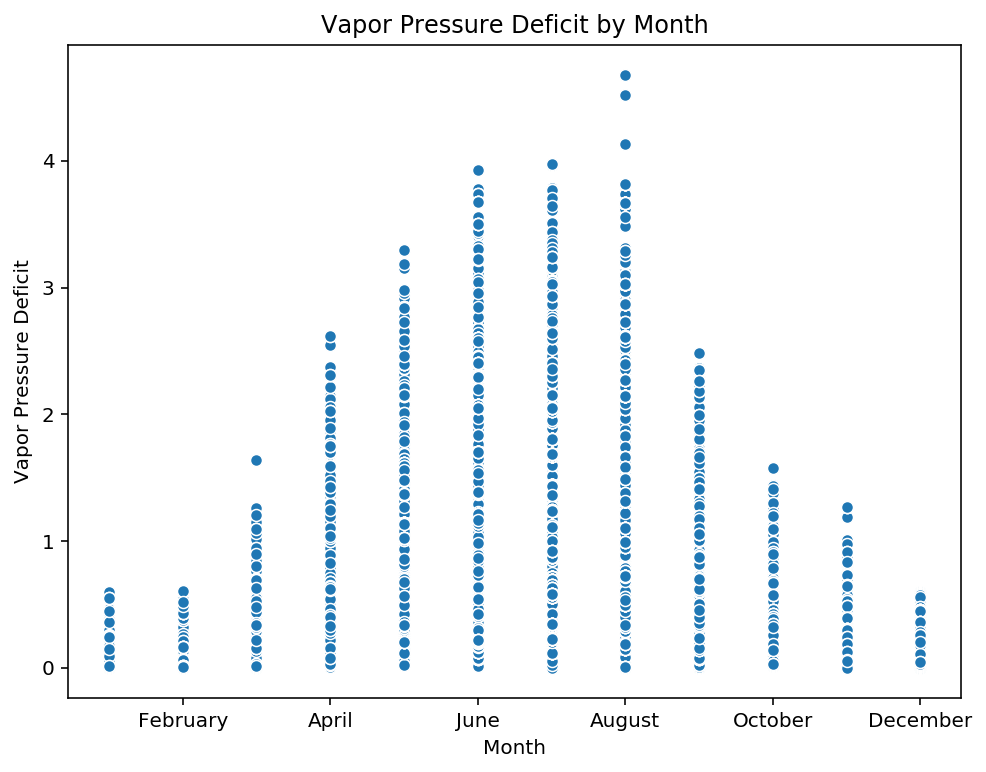

In [65]:
_ = plt.figure(figsize=(8, 6))
_ = plt.title("Vapor Pressure Deficit by Month")
ax = sns.scatterplot(x="month", y="vpd", data=df)
_ = plt.xlabel("Month")
_ = plt.ylabel("Vapor Pressure Deficit")
_ = ax.xaxis.set_major_formatter(month_tick_formatter)

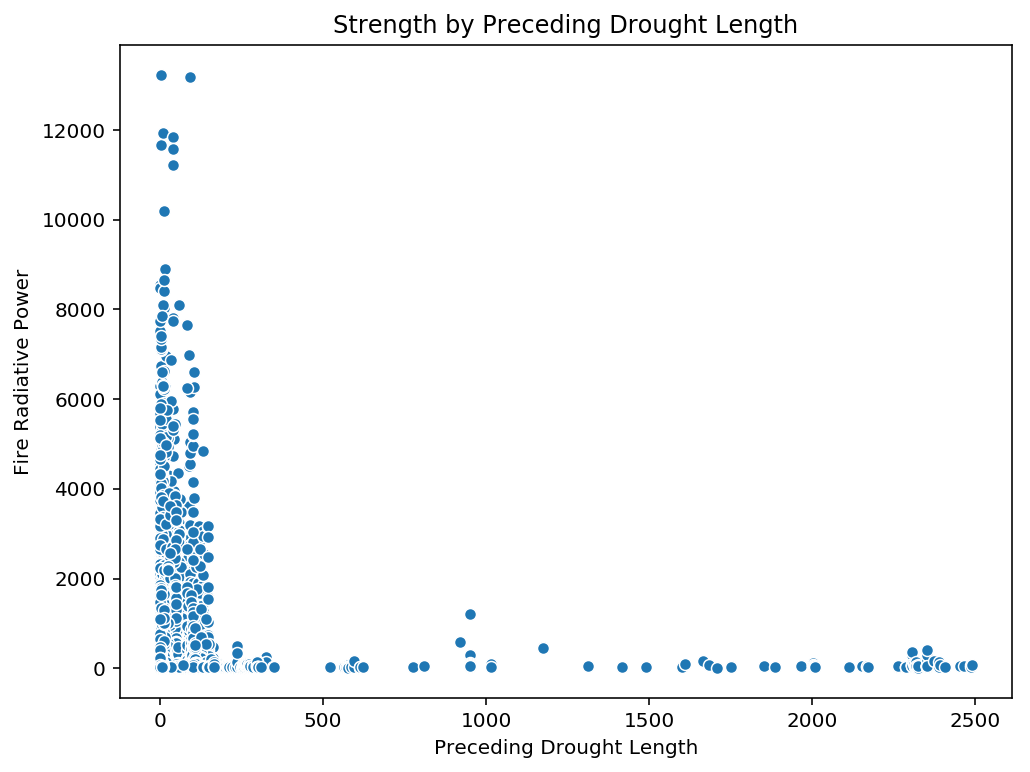

In [83]:
_ = plt.figure(figsize=(8, 6))
_ = plt.title("Strength by Preceding Drought Length")
_ = sns.scatterplot(x="drought_length", y="frp", data=df)
_ = plt.xlabel("Preceding Drought Length")
_ = plt.ylabel("Fire Radiative Power")